This notebook is to help develop my 16831 reinforcement learning project

In [1]:
import gym
import ffmpeg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from datetime import datetime as dt
from PIL import Image

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.atari_wrappers import WarpFrame

In [2]:
ACTION_MAP = {
    0: "NOOP",
    1: "UP",
    2: "RIGHT",
    3: "LEFT",
    4: "DOWN",
    5: "UPRIGHT",
    6: "UPLEFT",
    7: "DOWNRIGHT",
    8: "DOWNLEFT"
}

In [3]:
env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array', obs_type='rgb')
# env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array', obs_type='grayscale')

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


In [4]:
obs_space = env.observation_space
action_space = env.action_space

In [5]:
obs_space.shape

(210, 160, 3)

In [6]:
obs_space

Box(0, 255, (210, 160, 3), uint8)

In [7]:
action_space

Discrete(9)

In [8]:
def setup_dirs(logging_base_path: str, include_subfolders: bool):
    
    # Create folder to store trajectories
    timestamp = dt.strftime(dt.now(), '%Y%m%d_%H%M%S')
    logging_path = os.path.join(logging_base_path, timestamp)
    os.mkdir(logging_path)
    
    if include_subfolders:
        os.mkdir(os.path.join(logging_path, 'images'))
    
    return logging_path

In [9]:
env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array', frameskip=1, obs_type='rgb')
# env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array', frameskip=1, obs_type='grayscale')

In [10]:
# env = WarpFrame(env)

In [13]:
# model = PPO('CnnPolicy', env, verbose=2, tensorboard_log='ppo_model_log')
model = DQN('CnnPolicy', env, buffer_size=50000, verbose=2, tensorboard_log='dqn_model_log_test')
# model = DQN('MlpPolicy', env, buffer_size=50000, verbose=2, tensorboard_log='dqn_model_log_gray')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 10.08GB > 8.15GB
  warnings.warn(


In [12]:
# model.learn(1000000, eval_log_path='ppo_model_log_eval')
model.learn(1000000, eval_log_path='dqn_model_log_eval_test')
# model.learn(1000000, eval_log_path='dqn_model_log_eval_gray')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [14]:
# model.save('ppo_prelim_cnn')

### Run and log simulation

In [16]:
# Initialize environment
env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array', frameskip=1)

# Set hyperparameters
moves = 10000 # Max number of steps the agent will take. May hit terminal state first
n_traj = 20 # Number of trajectories to gather per rollout

# Create parent directory and initialize list of trajectories
logging_dir_parent = setup_dirs(logging_base_path='/project/logs/PPO', include_subfolders=False)
trajectories = []

# Run full simulation for each trajectory
for traj in range(n_traj):
    
    print('\n Starting trajectory {}! \n'.format(traj+1))
    
    # Initialize individual trajectory with data to track for metrics
    logging_dir = setup_dirs(logging_base_path=logging_dir_parent, include_subfolders=True)
    trajectory = []
    
    # Reset environment and record initial state
    obs = env.reset()
    frame_image = Image.fromarray(obs[0]).resize((500,500))
    frame_image.save(os.path.join(logging_dir, 'images', 'frame_000000.jpg'))
    
    # Run the simulation either for pre-defined number of steps or until terminal state, whichever
    # comes first
    for move in range(moves):
        
        # Choose random action
#         random_action = env.action_space.sample()
        random_action = int(model.predict(obs)[0])
        
        # Execute action and record new_obs, reward, done, info, and status in step_updates
#         new_obs, reward, done, info, status = env.step(random_action)
        new_obs, reward, done, status = env.step(random_action)
        status.pop('rgb')

#         new_metrics = (reward, done, info, status)
        new_metrics = (reward, done, status)
        trajectory.append(new_metrics)
    
        # Print logs to track simulation progress and debug
        reward = trajectory[move][0]
        done = trajectory[move][1]
        status = trajectory[move][2]
#         status = trajectory[move][2]
#         info = trajectory[move][2]
#         status = trajectory[move][3]
        print('Move {move}: {action}, reward: {reward}, done: {done}, {status}' \
              .format(move=move+1, action=ACTION_MAP[random_action], reward=reward, done=done, status=status))
        frame_num = str(status['episode_frame_number']).zfill(6)

        # Capture image
        frame_image = env.render(mode = 'rgb_array') #env.render()
        frame_image = Image.fromarray(frame_image).resize((500,500))
        frame_image.save(os.path.join(logging_dir, 'images', 'frame_{}.jpg'.format(frame_num)))
    #     env.env.ale.saveScreenPNG('/16831_project/random_agent_images/test_frame_{}.png'.format(frame_num))
    
        obs = new_obs

        # Stop simulation if terminal state has been reached
        if done:
            print('Simulation has ended!')
            break
            
    trajectories.append(trajectory)
    
    # Create video for completed trajectory before moving to the next one
    print('Creating video for trajectory {}!'.format(traj+1))
    ffmpeg.input(os.path.join(logging_dir, 'images', '*.jpg'), pattern_type='glob') \
    .output(os.path.join(logging_dir, 'pacman.mp4')) \
    .run()
    
# Save all metrics to pickle file
assert len(trajectories) == n_traj
print('Pickling metrics!')
with open(os.path.join(logging_dir_parent, 'metrics.pickle'), 'wb') as pkl:
    pickle.dump(trajectories, pkl)
    pkl.close()


 Starting trajectory 1! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 1}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 2}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 3}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 5}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 6}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 7}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 8}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 9}
Move 10: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 10, 

Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 90}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 91}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 92}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 93}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 94}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 95}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 96}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 97}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 98}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 

Move 182: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 182, 'frame_number': 182}
Move 183: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 183, 'frame_number': 183}
Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 184}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 185}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 186}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 187}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 188}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 189}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 190}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 

Move 276: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 276, 'frame_number': 276}
Move 277: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 277, 'frame_number': 277}
Move 278: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 278}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 279}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 280}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 281}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 282}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 283}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 284}
Move 285: DOWNLEFT

Move 367: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 367, 'frame_number': 367}
Move 368: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 368, 'frame_number': 368}
Move 369: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 369, 'frame_number': 369}
Move 370: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 370, 'frame_number': 370}
Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 371}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 372}
Move 373: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 373}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 374}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 375}
Move 376: UPRIGHT, reward: 0.0, d

Move 457: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 457, 'frame_number': 457}
Move 458: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 458, 'frame_number': 458}
Move 459: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 459, 'frame_number': 459}
Move 460: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 460, 'frame_number': 460}
Move 461: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 461, 'frame_number': 461}
Move 462: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 462, 'frame_number': 462}
Move 463: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 463, 'frame_number': 463}
Move 464: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 464}
Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 465}
Move 466: UPLEFT, reward: 0.0, done: False, 

Move 551: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 551, 'frame_number': 551}
Move 552: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 552, 'frame_number': 552}
Move 553: UPLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 553, 'frame_number': 553}
Move 554: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 554, 'frame_number': 554}
Move 555: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 555, 'frame_number': 555}
Move 556: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 556}
Move 557: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 557}
Move 558: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 558}
Move 559: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 559}
Move 560: UP, reward: 0.0, done: False, {'lives': 3, 

Move 645: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 645, 'frame_number': 645}
Move 646: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 646, 'frame_number': 646}
Move 647: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 647, 'frame_number': 647}
Move 648: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 648, 'frame_number': 648}
Move 649: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 649, 'frame_number': 649}
Move 650: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 650, 'frame_number': 650}
Move 651: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 651, 'frame_number': 651}
Move 652: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 652}
Move 653: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 653}
Move 654: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_n

Move 738: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 738, 'frame_number': 738}
Move 739: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 739, 'frame_number': 739}
Move 740: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 740, 'frame_number': 740}
Move 741: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 741, 'frame_number': 741}
Move 742: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 742, 'frame_number': 742}
Move 743: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 743, 'frame_number': 743}
Move 744: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 744, 'frame_number': 744}
Move 745: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 745, 'frame_number': 745}
Move 746: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 746, 'frame_number': 746}
Move 747: RIGHT, reward: 0.0, done: False, {'l

Move 831: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 831, 'frame_number': 831}
Move 832: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 832, 'frame_number': 832}
Move 833: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 833, 'frame_number': 833}
Move 834: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 834, 'frame_number': 834}
Move 835: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 835, 'frame_number': 835}
Move 836: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 836, 'frame_number': 836}
Move 837: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 837, 'frame_number': 837}
Move 838: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 838, 'frame_number': 838}
Move 839: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 839, 'frame_number': 839}
Move 840: UP, reward: 0.0, done: False, {'lives': 2, 'epi

Move 924: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 924, 'frame_number': 924}
Move 925: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 925, 'frame_number': 925}
Move 926: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 926, 'frame_number': 926}
Move 927: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 927, 'frame_number': 927}
Move 928: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 928, 'frame_number': 928}
Move 929: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 929, 'frame_number': 929}
Move 930: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 930, 'frame_number': 930}
Move 931: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 931}
Move 932: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 932}
Move 933: DOWNLEFT, reward: 0.0, done: False, {'liv

Move 1017: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1017, 'frame_number': 1017}
Move 1018: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1018, 'frame_number': 1018}
Move 1019: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1019, 'frame_number': 1019}
Move 1020: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1020, 'frame_number': 1020}
Move 1021: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1021, 'frame_number': 1021}
Move 1022: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1022, 'frame_number': 1022}
Move 1023: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1023, 'frame_number': 1023}
Move 1024: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1024, 'frame_number': 1024}
Move 1025: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 1025}
Move 1026: DOWN, reward:

Move 1110: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1110, 'frame_number': 1110}
Move 1111: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1111, 'frame_number': 1111}
Move 1112: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1112, 'frame_number': 1112}
Move 1113: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1113, 'frame_number': 1113}
Move 1114: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1114, 'frame_number': 1114}
Move 1115: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1115, 'frame_number': 1115}
Move 1116: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1116, 'frame_number': 1116}
Move 1117: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1117, 'frame_number': 1117}
Move 1118: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1118, 'frame_number': 1118}
Move 1119: RIGHT,

Move 1203: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1203, 'frame_number': 1203}
Move 1204: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1204, 'frame_number': 1204}
Move 1205: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1205, 'frame_number': 1205}
Move 1206: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1206, 'frame_number': 1206}
Move 1207: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1207, 'frame_number': 1207}
Move 1208: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1208, 'frame_number': 1208}
Move 1209: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1209, 'frame_number': 1209}
Move 1210: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1210, 'frame_number': 1210}
Move 1211: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1211, 'frame_number': 1211}
Move 1212: UP, reward: 0.0, done: Fa

Move 1295: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1295, 'frame_number': 1295}
Move 1296: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1296, 'frame_number': 1296}
Move 1297: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1297, 'frame_number': 1297}
Move 1298: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1298, 'frame_number': 1298}
Move 1299: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1299, 'frame_number': 1299}
Move 1300: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1300, 'frame_number': 1300}
Move 1301: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1301, 'frame_number': 1301}
Move 1302: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1302, 'frame_number': 1302}
Move 1303: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1303, 'frame_number': 1303}
Move 1304: UP, reward: 0.0, done: False, {'liv

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 2! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 1338}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 1339}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 1340}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 1341}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 1342}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 1343}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 1344}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 1345}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 1346}
Move 10: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 1430}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 1431}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 1432}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 1433}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 1434}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 1435}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 1436}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 100, 'frame_number': 1437}
Move 101: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 101, 'frame_number': 1438}
Move 102: DOWN, reward: 0.0, done: False, {'lives': 3, 'epis

Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 1523}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 1524}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 1525}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 1526}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 1527}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 1528}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 1529}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 1530}
Move 194: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 194, 'frame_number': 1531}
Move 195: DOWN, reward: 0.0, done: False, {'li

Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 1616}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 1617}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 1618}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 1619}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 1620}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 1621}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 1622}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 1623}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 1624}
Move 288

Move 370: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 370, 'frame_number': 1707}
Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 1708}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 1709}
Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 1710}
Move 374: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 1711}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 1712}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 1713}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 1714}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 1715}
Move 379: UPRIGHT, rewar

Move 460: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 460, 'frame_number': 1797}
Move 461: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 461, 'frame_number': 1798}
Move 462: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 462, 'frame_number': 1799}
Move 463: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 463, 'frame_number': 1800}
Move 464: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 1801}
Move 465: UPLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 1802}
Move 466: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 1803}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 1804}
Move 468: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 1805}
Move 469: UPLEFT, reward: 0.0, done: False,

Move 553: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 553, 'frame_number': 1890}
Move 554: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 554, 'frame_number': 1891}
Move 555: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 555, 'frame_number': 1892}
Move 556: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 1893}
Move 557: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 1894}
Move 558: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 1895}
Move 559: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 1896}
Move 560: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 1897}
Move 561: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 1898}
Move 562: DOWN, reward: 0.0, done

Move 647: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 647, 'frame_number': 1984}
Move 648: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 648, 'frame_number': 1985}
Move 649: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 649, 'frame_number': 1986}
Move 650: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 650, 'frame_number': 1987}
Move 651: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 651, 'frame_number': 1988}
Move 652: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 1989}
Move 653: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 1990}
Move 654: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 1991}
Move 655: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 1992}
Move 656: DOWN, reward: 0.0, done: False, {'li

Move 740: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 740, 'frame_number': 2077}
Move 741: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 741, 'frame_number': 2078}
Move 742: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 742, 'frame_number': 2079}
Move 743: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 743, 'frame_number': 2080}
Move 744: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 744, 'frame_number': 2081}
Move 745: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 745, 'frame_number': 2082}
Move 746: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 746, 'frame_number': 2083}
Move 747: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 747, 'frame_number': 2084}
Move 748: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 748, 'frame_number': 2085}
Move 749: DOWN, reward: 0.0, done: False, {'li

Move 834: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 834, 'frame_number': 2171}
Move 835: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 835, 'frame_number': 2172}
Move 836: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 836, 'frame_number': 2173}
Move 837: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 837, 'frame_number': 2174}
Move 838: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 838, 'frame_number': 2175}
Move 839: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 839, 'frame_number': 2176}
Move 840: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 840, 'frame_number': 2177}
Move 841: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 841, 'frame_number': 2178}
Move 842: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 842, 'frame_number': 2179}
Move 843: UP, reward: 0.0, done: False, {'lives': 3, 'epis

Move 926: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 926, 'frame_number': 2263}
Move 927: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 927, 'frame_number': 2264}
Move 928: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 928, 'frame_number': 2265}
Move 929: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 929, 'frame_number': 2266}
Move 930: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 930, 'frame_number': 2267}
Move 931: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 2268}
Move 932: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 2269}
Move 933: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 2270}
Move 934: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 934, 'frame_number': 2271}
Move 935: RIGHT, reward: 0.0, done: F

Move 1015: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1015, 'frame_number': 2352}
Move 1016: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1016, 'frame_number': 2353}
Move 1017: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1017, 'frame_number': 2354}
Move 1018: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1018, 'frame_number': 2355}
Move 1019: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1019, 'frame_number': 2356}
Move 1020: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1020, 'frame_number': 2357}
Move 1021: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1021, 'frame_number': 2358}
Move 1022: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1022, 'frame_number': 2359}
Move 1023: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1023, 'frame_number': 2360}
Move 1024: UPR

Move 1109: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1109, 'frame_number': 2446}
Move 1110: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1110, 'frame_number': 2447}
Move 1111: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1111, 'frame_number': 2448}
Move 1112: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1112, 'frame_number': 2449}
Move 1113: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1113, 'frame_number': 2450}
Move 1114: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1114, 'frame_number': 2451}
Move 1115: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1115, 'frame_number': 2452}
Move 1116: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1116, 'frame_number': 2453}
Move 1117: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1117, 'frame_number': 2454}
Move 1118: UP, reward: 0.0, do

Move 1204: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1204, 'frame_number': 2541}
Move 1205: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1205, 'frame_number': 2542}
Move 1206: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1206, 'frame_number': 2543}
Move 1207: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1207, 'frame_number': 2544}
Move 1208: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1208, 'frame_number': 2545}
Move 1209: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1209, 'frame_number': 2546}
Move 1210: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1210, 'frame_number': 2547}
Move 1211: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1211, 'frame_number': 2548}
Move 1212: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1212, 'frame_number': 2549}
Move 1213: RIGHT, r

Move 1297: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1297, 'frame_number': 2634}
Move 1298: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1298, 'frame_number': 2635}
Move 1299: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1299, 'frame_number': 2636}
Move 1300: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1300, 'frame_number': 2637}
Move 1301: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1301, 'frame_number': 2638}
Move 1302: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1302, 'frame_number': 2639}
Move 1303: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1303, 'frame_number': 2640}
Move 1304: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1304, 'frame_number': 2641}
Move 1305: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1305, 'frame_number': 2642}
Move 1306: UP, r

Move 1391: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1391, 'frame_number': 2728}
Move 1392: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1392, 'frame_number': 2729}
Move 1393: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1393, 'frame_number': 2730}
Move 1394: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1394, 'frame_number': 2731}
Move 1395: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1395, 'frame_number': 2732}
Move 1396: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1396, 'frame_number': 2733}
Move 1397: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1397, 'frame_number': 2734}
Move 1398: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1398, 'frame_number': 2735}
Move 1399: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1399, 'frame_number': 2736}
Move 1400: UP, reward: 0.0

Move 1485: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1485, 'frame_number': 2822}
Move 1486: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1486, 'frame_number': 2823}
Move 1487: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1487, 'frame_number': 2824}
Move 1488: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1488, 'frame_number': 2825}
Move 1489: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1489, 'frame_number': 2826}
Move 1490: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1490, 'frame_number': 2827}
Move 1491: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1491, 'frame_number': 2828}
Move 1492: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1492, 'frame_number': 2829}
Move 1493: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1493, 'frame_number': 2830}
Move 1494: DOWN

Move 1579: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1579, 'frame_number': 2916}
Move 1580: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1580, 'frame_number': 2917}
Move 1581: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1581, 'frame_number': 2918}
Move 1582: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1582, 'frame_number': 2919}
Move 1583: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1583, 'frame_number': 2920}
Move 1584: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1584, 'frame_number': 2921}
Move 1585: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1585, 'frame_number': 2922}
Move 1586: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1586, 'frame_number': 2923}
Move 1587: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1587, 'frame_number': 2924}
Move 1588: UP, reward: 0.0, done: False, {

Move 1673: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1673, 'frame_number': 3010}
Move 1674: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1674, 'frame_number': 3011}
Move 1675: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1675, 'frame_number': 3012}
Move 1676: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1676, 'frame_number': 3013}
Move 1677: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1677, 'frame_number': 3014}
Move 1678: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1678, 'frame_number': 3015}
Move 1679: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1679, 'frame_number': 3016}
Move 1680: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1680, 'frame_number': 3017}
Move 1681: UPLEFT, reward: 0.0, done: False, {'lives': 0, 'episode_frame_number': 1681, 'frame_number': 3018}
Move 1682: RIGHT, reward

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 3! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 3019}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 3020}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 3021}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 3022}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 3023}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 3024}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 3025}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 3026}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 3027}
Move 10: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 89: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 89, 'frame_number': 3107}
Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 3108}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 3109}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 3110}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 3111}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 3112}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 3113}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 3114}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 3115}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_f

Move 182: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 182, 'frame_number': 3200}
Move 183: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 183, 'frame_number': 3201}
Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 3202}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 3203}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 3204}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 3205}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 3206}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 3207}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 3208}
Move 191: DOWN, reward: 0.0, done: False, {'li

Move 275: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 275, 'frame_number': 3293}
Move 276: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 276, 'frame_number': 3294}
Move 277: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 277, 'frame_number': 3295}
Move 278: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 3296}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 3297}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 3298}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 3299}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 3300}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 3301}
Move 284:

Move 365: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 365, 'frame_number': 3383}
Move 366: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 366, 'frame_number': 3384}
Move 367: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 367, 'frame_number': 3385}
Move 368: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 368, 'frame_number': 3386}
Move 369: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 369, 'frame_number': 3387}
Move 370: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 370, 'frame_number': 3388}
Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 3389}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 3390}
Move 373: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 3391}
Move 374: UPRIGHT,

Move 458: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 458, 'frame_number': 3476}
Move 459: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 459, 'frame_number': 3477}
Move 460: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 460, 'frame_number': 3478}
Move 461: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 461, 'frame_number': 3479}
Move 462: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 462, 'frame_number': 3480}
Move 463: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 463, 'frame_number': 3481}
Move 464: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 3482}
Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 3483}
Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 3484}
Move 467: DOWNLEFT, reward: 0.0, don

Move 550: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 550, 'frame_number': 3568}
Move 551: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 551, 'frame_number': 3569}
Move 552: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 552, 'frame_number': 3570}
Move 553: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 553, 'frame_number': 3571}
Move 554: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 554, 'frame_number': 3572}
Move 555: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 555, 'frame_number': 3573}
Move 556: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 3574}
Move 557: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 3575}
Move 558: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 3576}
Move 559: UP, reward: 0.0, done: False, {'lives': 

Move 635: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 635, 'frame_number': 3653}
Move 636: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 636, 'frame_number': 3654}
Move 637: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 637, 'frame_number': 3655}
Move 638: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 638, 'frame_number': 3656}
Move 639: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 639, 'frame_number': 3657}
Move 640: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 640, 'frame_number': 3658}
Move 641: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 641, 'frame_number': 3659}
Move 642: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 642, 'frame_number': 3660}
Move 643: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 643, 'frame_number': 3661}
Move 644: UP, reward: 0.0, d

Move 726: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 726, 'frame_number': 3744}
Move 727: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 727, 'frame_number': 3745}
Move 728: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 728, 'frame_number': 3746}
Move 729: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 729, 'frame_number': 3747}
Move 730: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 730, 'frame_number': 3748}
Move 731: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 731, 'frame_number': 3749}
Move 732: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 732, 'frame_number': 3750}
Move 733: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 733, 'frame_number': 3751}
Move 734: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 734, 'frame_number': 3752}
Move 735: RIGHT, reward: 0.0, done: Fa

Move 815: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 815, 'frame_number': 3833}
Move 816: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 816, 'frame_number': 3834}
Move 817: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 817, 'frame_number': 3835}
Move 818: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 818, 'frame_number': 3836}
Move 819: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 819, 'frame_number': 3837}
Move 820: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 820, 'frame_number': 3838}
Move 821: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 821, 'frame_number': 3839}
Move 822: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 822, 'frame_number': 3840}
Move 823: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 823, 'frame_number': 3841}
Move 824: RIGHT, reward: 0.0, done: F

Move 909: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 909, 'frame_number': 3927}
Move 910: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 910, 'frame_number': 3928}
Move 911: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 911, 'frame_number': 3929}
Move 912: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 912, 'frame_number': 3930}
Move 913: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 913, 'frame_number': 3931}
Move 914: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 914, 'frame_number': 3932}
Move 915: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 915, 'frame_number': 3933}
Move 916: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 916, 'frame_number': 3934}
Move 917: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 917, 'frame_number': 3935}
Move 918: DOWN, reward: 0.0, done: False, 

Move 1002: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1002, 'frame_number': 4020}
Move 1003: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1003, 'frame_number': 4021}
Move 1004: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1004, 'frame_number': 4022}
Move 1005: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1005, 'frame_number': 4023}
Move 1006: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1006, 'frame_number': 4024}
Move 1007: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1007, 'frame_number': 4025}
Move 1008: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1008, 'frame_number': 4026}
Move 1009: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1009, 'frame_number': 4027}
Move 1010: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1010, 'frame_number': 4028}
Move 1011: DOWN, reward: 0.0, 

Move 1095: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1095, 'frame_number': 4113}
Move 1096: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1096, 'frame_number': 4114}
Move 1097: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1097, 'frame_number': 4115}
Move 1098: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1098, 'frame_number': 4116}
Move 1099: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1099, 'frame_number': 4117}
Move 1100: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1100, 'frame_number': 4118}
Move 1101: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1101, 'frame_number': 4119}
Move 1102: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1102, 'frame_number': 4120}
Move 1103: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1103, 'frame_number': 4121}
Move 1104: DOWN, reward:

Move 1189: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1189, 'frame_number': 4207}
Move 1190: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1190, 'frame_number': 4208}
Move 1191: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1191, 'frame_number': 4209}
Move 1192: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1192, 'frame_number': 4210}
Move 1193: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1193, 'frame_number': 4211}
Move 1194: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1194, 'frame_number': 4212}
Move 1195: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1195, 'frame_number': 4213}
Move 1196: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1196, 'frame_number': 4214}
Move 1197: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1197, 'frame_number': 4215}
Move 1198: 

Move 1281: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1281, 'frame_number': 4299}
Move 1282: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1282, 'frame_number': 4300}
Move 1283: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1283, 'frame_number': 4301}
Move 1284: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1284, 'frame_number': 4302}
Move 1285: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1285, 'frame_number': 4303}
Move 1286: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1286, 'frame_number': 4304}
Move 1287: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1287, 'frame_number': 4305}
Move 1288: DOWNRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1288, 'frame_number': 4306}
Move 1289: UPLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1289, 'frame_number': 4307}
Move 12

Move 1373: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1373, 'frame_number': 4391}
Move 1374: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1374, 'frame_number': 4392}
Move 1375: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1375, 'frame_number': 4393}
Move 1376: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1376, 'frame_number': 4394}
Move 1377: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1377, 'frame_number': 4395}
Move 1378: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1378, 'frame_number': 4396}
Move 1379: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1379, 'frame_number': 4397}
Move 1380: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1380, 'frame_number': 4398}
Move 1381: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1381, 'frame_number': 4399}
Move 

Move 1465: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1465, 'frame_number': 4483}
Move 1466: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1466, 'frame_number': 4484}
Move 1467: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1467, 'frame_number': 4485}
Move 1468: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1468, 'frame_number': 4486}
Move 1469: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1469, 'frame_number': 4487}
Move 1470: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1470, 'frame_number': 4488}
Move 1471: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1471, 'frame_number': 4489}
Move 1472: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1472, 'frame_number': 4490}
Move 1473: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1473, 'frame_number': 4491}
Move 147

Move 1558: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1558, 'frame_number': 4576}
Move 1559: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1559, 'frame_number': 4577}
Move 1560: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1560, 'frame_number': 4578}
Move 1561: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1561, 'frame_number': 4579}
Move 1562: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1562, 'frame_number': 4580}
Move 1563: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1563, 'frame_number': 4581}
Move 1564: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1564, 'frame_number': 4582}
Move 1565: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1565, 'frame_number': 4583}
Move 1566: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1566, 'frame_number': 4584}
Move 1567: UP, reward: 0.0, done

Move 1652: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1652, 'frame_number': 4670}
Move 1653: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1653, 'frame_number': 4671}
Move 1654: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1654, 'frame_number': 4672}
Move 1655: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1655, 'frame_number': 4673}
Move 1656: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1656, 'frame_number': 4674}
Move 1657: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1657, 'frame_number': 4675}
Move 1658: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1658, 'frame_number': 4676}
Move 1659: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1659, 'frame_number': 4677}
Move 1660: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1660, 'frame_number': 4678}
Move 1661: UP, reward: 0.0

Move 1745: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1745, 'frame_number': 4763}
Move 1746: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1746, 'frame_number': 4764}
Move 1747: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1747, 'frame_number': 4765}
Move 1748: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1748, 'frame_number': 4766}
Move 1749: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1749, 'frame_number': 4767}
Move 1750: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1750, 'frame_number': 4768}
Move 1751: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1751, 'frame_number': 4769}
Move 1752: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1752, 'frame_number': 4770}
Move 1753: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1753, 'frame_number': 4771}
Move 1754: RIGHT, r

Move 1837: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1837, 'frame_number': 4855}
Move 1838: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1838, 'frame_number': 4856}
Move 1839: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1839, 'frame_number': 4857}
Move 1840: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1840, 'frame_number': 4858}
Move 1841: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1841, 'frame_number': 4859}
Move 1842: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1842, 'frame_number': 4860}
Move 1843: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1843, 'frame_number': 4861}
Move 1844: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1844, 'frame_number': 4862}
Move 1845: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1845, 'frame_number': 4863}
Move 1846: UP, reward: 0.0, done: Fals

Move 1928: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1928, 'frame_number': 4946}
Move 1929: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1929, 'frame_number': 4947}
Move 1930: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1930, 'frame_number': 4948}
Move 1931: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1931, 'frame_number': 4949}
Move 1932: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1932, 'frame_number': 4950}
Move 1933: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1933, 'frame_number': 4951}
Move 1934: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1934, 'frame_number': 4952}
Move 1935: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1935, 'frame_number': 4953}
Move 1936: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1936, 'frame_number': 4954}
Move 1937: 

Move 2022: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2022, 'frame_number': 5040}
Move 2023: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2023, 'frame_number': 5041}
Move 2024: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2024, 'frame_number': 5042}
Move 2025: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2025, 'frame_number': 5043}
Move 2026: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2026, 'frame_number': 5044}
Move 2027: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2027, 'frame_number': 5045}
Move 2028: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2028, 'frame_number': 5046}
Move 2029: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2029, 'frame_number': 5047}
Move 2030: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2030, 'frame_number': 5048}
Move 2031: UP, rew

Move 2116: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2116, 'frame_number': 5134}
Move 2117: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2117, 'frame_number': 5135}
Move 2118: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2118, 'frame_number': 5136}
Move 2119: UPRIGHT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 2119, 'frame_number': 5137}
Move 2120: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2120, 'frame_number': 5138}
Move 2121: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2121, 'frame_number': 5139}
Move 2122: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2122, 'frame_number': 5140}
Move 2123: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2123, 'frame_number': 5141}
Move 2124: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2124, 'frame_number': 5142}
Move 212

Move 2210: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2210, 'frame_number': 5228}
Move 2211: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2211, 'frame_number': 5229}
Move 2212: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2212, 'frame_number': 5230}
Move 2213: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2213, 'frame_number': 5231}
Move 2214: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2214, 'frame_number': 5232}
Move 2215: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2215, 'frame_number': 5233}
Move 2216: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2216, 'frame_number': 5234}
Move 2217: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2217, 'frame_number': 5235}
Move 2218: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2218, 'frame_number': 5236}
Move 2219: UPRIG

Move 2304: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2304, 'frame_number': 5322}
Move 2305: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2305, 'frame_number': 5323}
Move 2306: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2306, 'frame_number': 5324}
Move 2307: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2307, 'frame_number': 5325}
Move 2308: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2308, 'frame_number': 5326}
Move 2309: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2309, 'frame_number': 5327}
Move 2310: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2310, 'frame_number': 5328}
Move 2311: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2311, 'frame_number': 5329}
Move 2312: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2312, 'frame_number': 5330}
Move 2313: UPLEFT, re

Move 2396: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2396, 'frame_number': 5414}
Move 2397: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2397, 'frame_number': 5415}
Move 2398: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2398, 'frame_number': 5416}
Move 2399: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2399, 'frame_number': 5417}
Move 2400: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2400, 'frame_number': 5418}
Move 2401: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2401, 'frame_number': 5419}
Move 2402: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2402, 'frame_number': 5420}
Move 2403: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2403, 'frame_number': 5421}
Move 2404: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2404, 'frame_number': 5422}
Mov

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 4! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 5476}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 5477}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 5478}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 5479}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 5480}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 5481}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 5482}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 5483}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 5484}
Move 10: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 5566}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 5567}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 5568}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 5569}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 5570}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 5571}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 5572}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 5573}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 5574}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_

Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 5660}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 5661}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 5662}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 5663}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 5664}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 5665}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 5666}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 5667}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 5668}
Move 194: DOWN, reward: 0.0, done: False, {'li

Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 5754}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 5755}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 5756}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 5757}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 5758}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 5759}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 5760}
Move 286: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 5761}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 5762}
Move 288: DOW

Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 5846}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 5847}
Move 373: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 5848}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 5849}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 5850}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 5851}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 5852}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 5853}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 5854}
Move 380: UPRIGHT,

Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 5940}
Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 5941}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 5942}
Move 468: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 5943}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 5944}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 5945}
Move 471: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 5946}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 5947}
Move 473: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 5948}
Move 474: UPLEFT, reward: 0.0, done: Fal

Move 559: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 6034}
Move 560: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 6035}
Move 561: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 6036}
Move 562: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 6037}
Move 563: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 6038}
Move 564: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 6039}
Move 565: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 6040}
Move 566: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 6041}
Move 567: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 6042}
Move 568: UPRIGHT, rew

Move 653: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 6128}
Move 654: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 6129}
Move 655: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 6130}
Move 656: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 6131}
Move 657: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 6132}
Move 658: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 6133}
Move 659: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 6134}
Move 660: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 6135}
Move 661: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 661, 'frame_number': 6136}
Move 662: DOWN, reward: 0.0, done: False, {'lives': 

Move 747: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 747, 'frame_number': 6222}
Move 748: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 748, 'frame_number': 6223}
Move 749: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 749, 'frame_number': 6224}
Move 750: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 750, 'frame_number': 6225}
Move 751: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 751, 'frame_number': 6226}
Move 752: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 752, 'frame_number': 6227}
Move 753: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 753, 'frame_number': 6228}
Move 754: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 754, 'frame_number': 6229}
Move 755: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 755, 'frame_number': 6230}
Move 756: RIGHT, reward: 0.0, done: False

Move 840: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 840, 'frame_number': 6315}
Move 841: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 841, 'frame_number': 6316}
Move 842: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 842, 'frame_number': 6317}
Move 843: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 843, 'frame_number': 6318}
Move 844: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 844, 'frame_number': 6319}
Move 845: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 845, 'frame_number': 6320}
Move 846: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 846, 'frame_number': 6321}
Move 847: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 847, 'frame_number': 6322}
Move 848: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 848, 'frame_number': 6323}
Move 849: DOWN, reward: 0.0, done: False, {'lives': 2,

Move 936: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 6411}
Move 937: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 6412}
Move 938: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 6413}
Move 939: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 6414}
Move 940: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 940, 'frame_number': 6415}
Move 941: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 941, 'frame_number': 6416}
Move 942: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 942, 'frame_number': 6417}
Move 943: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 943, 'frame_number': 6418}
Move 944: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 944, 'frame_number': 6419}
Move 945: UPLEFT, reward: 0.0, done: Fals

Move 1029: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1029, 'frame_number': 6504}
Move 1030: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1030, 'frame_number': 6505}
Move 1031: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1031, 'frame_number': 6506}
Move 1032: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1032, 'frame_number': 6507}
Move 1033: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1033, 'frame_number': 6508}
Move 1034: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1034, 'frame_number': 6509}
Move 1035: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1035, 'frame_number': 6510}
Move 1036: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1036, 'frame_number': 6511}
Move 1037: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1037, 'frame_number': 6512}
Move 1038: UPLEFT,

Move 1121: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1121, 'frame_number': 6596}
Move 1122: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1122, 'frame_number': 6597}
Move 1123: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1123, 'frame_number': 6598}
Move 1124: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1124, 'frame_number': 6599}
Move 1125: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1125, 'frame_number': 6600}
Move 1126: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1126, 'frame_number': 6601}
Move 1127: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1127, 'frame_number': 6602}
Move 1128: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1128, 'frame_number': 6603}
Move 1129: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1129, 'frame_number': 6604}
Move 1130: UPLEFT, reward

Move 1206: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1206, 'frame_number': 6681}
Move 1207: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1207, 'frame_number': 6682}
Move 1208: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1208, 'frame_number': 6683}
Move 1209: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1209, 'frame_number': 6684}
Move 1210: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1210, 'frame_number': 6685}
Move 1211: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1211, 'frame_number': 6686}
Move 1212: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1212, 'frame_number': 6687}
Move 1213: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1213, 'frame_number': 6688}
Move 1214: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1214, 'frame_number': 6689}
Move 1215: DOWN, reward: 0.0, done: 

Move 1299: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1299, 'frame_number': 6774}
Move 1300: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1300, 'frame_number': 6775}
Move 1301: UPLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1301, 'frame_number': 6776}
Move 1302: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1302, 'frame_number': 6777}
Move 1303: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1303, 'frame_number': 6778}
Move 1304: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1304, 'frame_number': 6779}
Move 1305: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1305, 'frame_number': 6780}
Move 1306: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1306, 'frame_number': 6781}
Move 1307: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1307, 'frame_number': 6782}
Move 1308

Move 1392: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1392, 'frame_number': 6867}
Move 1393: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1393, 'frame_number': 6868}
Move 1394: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1394, 'frame_number': 6869}
Move 1395: UPLEFT, reward: 50.0, done: False, {'lives': 2, 'episode_frame_number': 1395, 'frame_number': 6870}
Move 1396: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1396, 'frame_number': 6871}
Move 1397: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1397, 'frame_number': 6872}
Move 1398: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1398, 'frame_number': 6873}
Move 1399: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1399, 'frame_number': 6874}
Move 1400: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1400, 'frame_number': 6875}
Move 14

Move 1486: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1486, 'frame_number': 6961}
Move 1487: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1487, 'frame_number': 6962}
Move 1488: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1488, 'frame_number': 6963}
Move 1489: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1489, 'frame_number': 6964}
Move 1490: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1490, 'frame_number': 6965}
Move 1491: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1491, 'frame_number': 6966}
Move 1492: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1492, 'frame_number': 6967}
Move 1493: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1493, 'frame_number': 6968}
Move 1494: DOWNRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1494, 'frame_number

Move 1579: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1579, 'frame_number': 7054}
Move 1580: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1580, 'frame_number': 7055}
Move 1581: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1581, 'frame_number': 7056}
Move 1582: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1582, 'frame_number': 7057}
Move 1583: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1583, 'frame_number': 7058}
Move 1584: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1584, 'frame_number': 7059}
Move 1585: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1585, 'frame_number': 7060}
Move 1586: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1586, 'frame_number': 7061}
Move 1587: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1587, 'frame_number': 7062}
Mo

Move 1672: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1672, 'frame_number': 7147}
Move 1673: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1673, 'frame_number': 7148}
Move 1674: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1674, 'frame_number': 7149}
Move 1675: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1675, 'frame_number': 7150}
Move 1676: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1676, 'frame_number': 7151}
Move 1677: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1677, 'frame_number': 7152}
Move 1678: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1678, 'frame_number': 7153}
Move 1679: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1679, 'frame_number': 7154}
Move 1680: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1680, 'frame_number': 7

Move 1765: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1765, 'frame_number': 7240}
Move 1766: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1766, 'frame_number': 7241}
Move 1767: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1767, 'frame_number': 7242}
Move 1768: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1768, 'frame_number': 7243}
Move 1769: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1769, 'frame_number': 7244}
Move 1770: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1770, 'frame_number': 7245}
Move 1771: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1771, 'frame_number': 7246}
Move 1772: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1772, 'frame_number': 7247}
Move 1773: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1773, 'frame_number': 7248}

Move 1859: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1859, 'frame_number': 7334}
Move 1860: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1860, 'frame_number': 7335}
Move 1861: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1861, 'frame_number': 7336}
Move 1862: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1862, 'frame_number': 7337}
Move 1863: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1863, 'frame_number': 7338}
Move 1864: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1864, 'frame_number': 7339}
Move 1865: UPRIGHT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1865, 'frame_number': 7340}
Move 1866: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1866, 'frame_number': 7341}
Move 1867: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1867, 'frame_number': 7342}


Move 1952: DOWNRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1952, 'frame_number': 7427}
Move 1953: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1953, 'frame_number': 7428}
Move 1954: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1954, 'frame_number': 7429}
Move 1955: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1955, 'frame_number': 7430}
Move 1956: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1956, 'frame_number': 7431}
Move 1957: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1957, 'frame_number': 7432}
Move 1958: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1958, 'frame_number': 7433}
Move 1959: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1959, 'frame_number': 7434}
Move 1960: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1960, 'frame_number': 7435}
M

Move 2045: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2045, 'frame_number': 7520}
Move 2046: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2046, 'frame_number': 7521}
Move 2047: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2047, 'frame_number': 7522}
Move 2048: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2048, 'frame_number': 7523}
Move 2049: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2049, 'frame_number': 7524}
Move 2050: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2050, 'frame_number': 7525}
Move 2051: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2051, 'frame_number': 7526}
Move 2052: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2052, 'frame_number': 7527}
Move 2053: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2053, 'frame_number': 7528}
Mov

Move 2129: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2129, 'frame_number': 7604}
Move 2130: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2130, 'frame_number': 7605}
Move 2131: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2131, 'frame_number': 7606}
Move 2132: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2132, 'frame_number': 7607}
Move 2133: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2133, 'frame_number': 7608}
Move 2134: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2134, 'frame_number': 7609}
Move 2135: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2135, 'frame_number': 7610}
Move 2136: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2136, 'frame_number': 7611}
Move 2137: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2137, 'frame_number': 7612}


Move 2221: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2221, 'frame_number': 7696}
Move 2222: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2222, 'frame_number': 7697}
Move 2223: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2223, 'frame_number': 7698}
Move 2224: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2224, 'frame_number': 7699}
Move 2225: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2225, 'frame_number': 7700}
Move 2226: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2226, 'frame_number': 7701}
Move 2227: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2227, 'frame_number': 7702}
Move 2228: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2228, 'frame_number': 7703}
Move 2229: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2229, 'frame_number': 7704}
Move 22

Move 2315: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2315, 'frame_number': 7790}
Move 2316: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2316, 'frame_number': 7791}
Move 2317: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2317, 'frame_number': 7792}
Move 2318: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2318, 'frame_number': 7793}
Move 2319: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2319, 'frame_number': 7794}
Move 2320: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2320, 'frame_number': 7795}
Move 2321: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2321, 'frame_number': 7796}
Move 2322: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2322, 'frame_number': 7797}
Move 2323: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2323, 'frame_number': 7798}
Move 2324: UP, rew

Move 2408: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2408, 'frame_number': 7883}
Move 2409: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2409, 'frame_number': 7884}
Move 2410: DOWNRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2410, 'frame_number': 7885}
Move 2411: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2411, 'frame_number': 7886}
Move 2412: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2412, 'frame_number': 7887}
Move 2413: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2413, 'frame_number': 7888}
Move 2414: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2414, 'frame_number': 7889}
Move 2415: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2415, 'frame_number': 7890}
Move 2416: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2416, 'frame_number': 78

Move 2500: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2500, 'frame_number': 7975}
Move 2501: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2501, 'frame_number': 7976}
Move 2502: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2502, 'frame_number': 7977}
Move 2503: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2503, 'frame_number': 7978}
Move 2504: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2504, 'frame_number': 7979}
Move 2505: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2505, 'frame_number': 7980}
Move 2506: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2506, 'frame_number': 7981}
Move 2507: UPRIGHT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 2507, 'frame_number': 7982}
Move 2508: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2508, 'frame_number': 7983}
Move 2509: U

Move 2592: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2592, 'frame_number': 8067}
Move 2593: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2593, 'frame_number': 8068}
Move 2594: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2594, 'frame_number': 8069}
Move 2595: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2595, 'frame_number': 8070}
Move 2596: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2596, 'frame_number': 8071}
Move 2597: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2597, 'frame_number': 8072}
Move 2598: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2598, 'frame_number': 8073}
Move 2599: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2599, 'frame_number': 8074}
Move 2600: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2600, 'frame_number': 8075}
Move 2601: UPLE

Move 2684: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2684, 'frame_number': 8159}
Move 2685: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2685, 'frame_number': 8160}
Move 2686: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2686, 'frame_number': 8161}
Move 2687: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2687, 'frame_number': 8162}
Move 2688: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2688, 'frame_number': 8163}
Move 2689: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2689, 'frame_number': 8164}
Move 2690: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2690, 'frame_number': 8165}
Move 2691: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2691, 'frame_number': 8166}
Move 2692: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2692, 'frame_number': 8167}
Move 2693: UPL

Move 2776: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2776, 'frame_number': 8251}
Move 2777: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2777, 'frame_number': 8252}
Move 2778: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2778, 'frame_number': 8253}
Move 2779: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2779, 'frame_number': 8254}
Move 2780: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2780, 'frame_number': 8255}
Move 2781: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2781, 'frame_number': 8256}
Move 2782: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2782, 'frame_number': 8257}
Move 2783: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2783, 'frame_number': 8258}
Move 2784: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2784, 'frame_number': 8259}
Move 2785: RIGHT, r

Move 2869: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2869, 'frame_number': 8344}
Move 2870: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2870, 'frame_number': 8345}
Move 2871: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2871, 'frame_number': 8346}
Move 2872: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2872, 'frame_number': 8347}
Move 2873: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2873, 'frame_number': 8348}
Move 2874: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2874, 'frame_number': 8349}
Move 2875: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2875, 'frame_number': 8350}
Move 2876: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2876, 'frame_number': 8351}
Move 2877: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2877, 'frame_number': 8352}
Move 

Move 2963: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2963, 'frame_number': 8438}
Move 2964: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2964, 'frame_number': 8439}
Move 2965: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2965, 'frame_number': 8440}
Move 2966: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2966, 'frame_number': 8441}
Move 2967: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2967, 'frame_number': 8442}
Move 2968: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2968, 'frame_number': 8443}
Move 2969: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2969, 'frame_number': 8444}
Move 2970: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2970, 'frame_number': 8445}
Move 2971: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2971, 'frame_number': 8446}
Move 

Move 3057: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3057, 'frame_number': 8532}
Move 3058: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3058, 'frame_number': 8533}
Move 3059: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3059, 'frame_number': 8534}
Move 3060: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3060, 'frame_number': 8535}
Move 3061: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3061, 'frame_number': 8536}
Move 3062: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3062, 'frame_number': 8537}
Move 3063: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3063, 'frame_number': 8538}
Move 3064: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3064, 'frame_number': 8539}
Move 3065: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3065, 'frame_number': 8540}
Move 3066: UPRIGHT, rew

Move 3152: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3152, 'frame_number': 8627}
Move 3153: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3153, 'frame_number': 8628}
Move 3154: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3154, 'frame_number': 8629}
Move 3155: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3155, 'frame_number': 8630}
Move 3156: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3156, 'frame_number': 8631}
Move 3157: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3157, 'frame_number': 8632}
Move 3158: DOWNRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3158, 'frame_number': 8633}
Move 3159: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3159, 'frame_number': 8634}
Move 3160: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3160, 'frame_number': 8635}
Move 3161: DOWNLEFT, 

Move 3246: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3246, 'frame_number': 8721}
Move 3247: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3247, 'frame_number': 8722}
Move 3248: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3248, 'frame_number': 8723}
Move 3249: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3249, 'frame_number': 8724}
Move 3250: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3250, 'frame_number': 8725}
Move 3251: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3251, 'frame_number': 8726}
Move 3252: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3252, 'frame_number': 8727}
Move 3253: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3253, 'frame_number': 8728}
Move 3254: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3254, 'frame_number': 8729}
Move 325

Move 3340: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3340, 'frame_number': 8815}
Move 3341: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3341, 'frame_number': 8816}
Move 3342: NOOP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3342, 'frame_number': 8817}
Move 3343: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3343, 'frame_number': 8818}
Move 3344: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 3344, 'frame_number': 8819}
Move 3345: DOWNLEFT, reward: 0.0, done: False, {'lives': 0, 'episode_frame_number': 3345, 'frame_number': 8820}
Move 3346: NOOP, reward: 0.0, done: True, {'lives': 0, 'episode_frame_number': 3345, 'frame_number': 8820}
Simulation has ended!
Creating video for trajectory 4!


ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 5! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 8821}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 8822}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 8823}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 8824}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 8825}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 8826}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 8827}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 8828}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 8829}
Move 10: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 8912}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 8913}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 8914}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 8915}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 8916}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 8917}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 8918}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 8919}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 100, 'frame_number': 8920}
Move 101: DOWN, reward: 0.0, done: False, {'lives': 3, 'episod

Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 9005}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 9006}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 9007}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 9008}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 9009}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 9010}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 9011}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 9012}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 9013}
Move 194: DOWN, reward: 0.0, done: False, {'li

Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 9100}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 9101}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 9102}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 9103}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 9104}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 9105}
Move 286: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 9106}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 9107}
Move 288: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 288, 'frame_number': 9108}
Move 289: DOW

Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 9193}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 9194}
Move 375: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 9195}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 9196}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 9197}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 9198}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 9199}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 9200}
Move 381: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 381, 'frame_number': 9201}
Move 382: UPRIGHT,

Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 9285}
Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 9286}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 9287}
Move 468: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 9288}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 9289}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 9290}
Move 471: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 9291}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 9292}
Move 473: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 9293}
Move 474: UP, reward: 0.0, don

Move 557: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 557, 'frame_number': 9377}
Move 558: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 558, 'frame_number': 9378}
Move 559: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 559, 'frame_number': 9379}
Move 560: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 560, 'frame_number': 9380}
Move 561: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 561, 'frame_number': 9381}
Move 562: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 562, 'frame_number': 9382}
Move 563: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 563, 'frame_number': 9383}
Move 564: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 564, 'frame_number': 9384}
Move 565: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 565, 'frame_number': 9385}
Move 566: DOWN, reward: 0.0, done: False, 

Move 651: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 651, 'frame_number': 9471}
Move 652: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 652, 'frame_number': 9472}
Move 653: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 653, 'frame_number': 9473}
Move 654: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 654, 'frame_number': 9474}
Move 655: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 655, 'frame_number': 9475}
Move 656: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 656, 'frame_number': 9476}
Move 657: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 657, 'frame_number': 9477}
Move 658: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 658, 'frame_number': 9478}
Move 659: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 659, 'frame_number': 9479}
Move 660: DOWN, reward: 0.0, done: False, {

Move 744: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 744, 'frame_number': 9564}
Move 745: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 745, 'frame_number': 9565}
Move 746: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 746, 'frame_number': 9566}
Move 747: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 747, 'frame_number': 9567}
Move 748: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 748, 'frame_number': 9568}
Move 749: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 749, 'frame_number': 9569}
Move 750: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 750, 'frame_number': 9570}
Move 751: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 751, 'frame_number': 9571}
Move 752: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 752, 'frame_number': 9572}
Move 753: UP, reward: 0.0, done: Fals

Move 838: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 838, 'frame_number': 9658}
Move 839: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 839, 'frame_number': 9659}
Move 840: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 840, 'frame_number': 9660}
Move 841: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 841, 'frame_number': 9661}
Move 842: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 842, 'frame_number': 9662}
Move 843: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 843, 'frame_number': 9663}
Move 844: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 844, 'frame_number': 9664}
Move 845: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 845, 'frame_number': 9665}
Move 846: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 846, 'frame_number': 9666}
Move 847: RIGHT, reward: 0.0, done: False, {

Move 932: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 932, 'frame_number': 9752}
Move 933: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 933, 'frame_number': 9753}
Move 934: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 934, 'frame_number': 9754}
Move 935: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 935, 'frame_number': 9755}
Move 936: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 936, 'frame_number': 9756}
Move 937: UP, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 937, 'frame_number': 9757}
Move 938: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 938, 'frame_number': 9758}
Move 939: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 939, 'frame_number': 9759}
Move 940: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 940, 'frame_number': 9760}
Move 941: DOWN, reward: 0.0, done: False, {'lives': 1, 

Move 1026: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1026, 'frame_number': 9846}
Move 1027: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1027, 'frame_number': 9847}
Move 1028: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1028, 'frame_number': 9848}
Move 1029: UPRIGHT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1029, 'frame_number': 9849}
Move 1030: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1030, 'frame_number': 9850}
Move 1031: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1031, 'frame_number': 9851}
Move 1032: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1032, 'frame_number': 9852}
Move 1033: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1033, 'frame_number': 9853}
Move 1034: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1034, 'frame_number': 9854}
Move 1035: UPRI

Move 1120: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1120, 'frame_number': 9940}
Move 1121: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1121, 'frame_number': 9941}
Move 1122: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1122, 'frame_number': 9942}
Move 1123: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1123, 'frame_number': 9943}
Move 1124: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1124, 'frame_number': 9944}
Move 1125: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1125, 'frame_number': 9945}
Move 1126: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1126, 'frame_number': 9946}
Move 1127: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1127, 'frame_number': 9947}
Move 1128: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1128, 'frame_number': 9948}
Move 1129: DOWNLEFT, rew

Move 1214: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1214, 'frame_number': 10034}
Move 1215: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1215, 'frame_number': 10035}
Move 1216: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1216, 'frame_number': 10036}
Move 1217: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1217, 'frame_number': 10037}
Move 1218: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1218, 'frame_number': 10038}
Move 1219: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1219, 'frame_number': 10039}
Move 1220: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1220, 'frame_number': 10040}
Move 1221: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1221, 'frame_number': 10041}
Move 1222: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1222, 'frame_number': 10042}
Move 1223: UP, reward: 0

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 6! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 10094}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 10095}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 10096}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 10097}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 10098}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 10099}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 10100}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 10101}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 10102}
Move 10: DOWN, reward: 0.0, done: False, {'liv

Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 10184}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 10185}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 10186}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 10187}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 10188}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 10189}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 10190}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 10191}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 10192}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 

Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 10277}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 10278}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 10279}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 10280}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 10281}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 10282}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 10283}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 10284}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 10285}
Move 193: DOWN, reward: 0.0, done: Fa

Move 278: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 10371}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 10372}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 10373}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 10374}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 10375}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 10376}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 10377}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 10378}
Move 286: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 10379}
Move

Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 10465}
Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 10466}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 10467}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 10468}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 10469}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 10470}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 10471}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 10472}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 10473}
Move 381: 

Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 10559}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 10560}
Move 468: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 10561}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 10562}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 10563}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 10564}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 10565}
Move 473: UPLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 10566}
Move 474: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 474, 'frame_number': 10567}
Move 475: UPLEFT, 

Move 560: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 10653}
Move 561: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 10654}
Move 562: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 10655}
Move 563: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 10656}
Move 564: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 10657}
Move 565: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 10658}
Move 566: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 10659}
Move 567: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 10660}
Move 568: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 568, 'frame_number': 10661}
Move 569: DOWNLEFT, reward:

Move 652: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 10745}
Move 653: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 10746}
Move 654: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 10747}
Move 655: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 10748}
Move 656: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 10749}
Move 657: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 10750}
Move 658: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 10751}
Move 659: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 10752}
Move 660: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 10753}
Move 661: UPRIGHT, reward: 0.0, do

Move 744: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 744, 'frame_number': 10837}
Move 745: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 745, 'frame_number': 10838}
Move 746: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 746, 'frame_number': 10839}
Move 747: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 747, 'frame_number': 10840}
Move 748: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 748, 'frame_number': 10841}
Move 749: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 749, 'frame_number': 10842}
Move 750: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 750, 'frame_number': 10843}
Move 751: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 751, 'frame_number': 10844}
Move 752: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 752, 'frame_number': 10845}
Move 753: DOWN, reward: 0.0, done

Move 837: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 837, 'frame_number': 10930}
Move 838: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 838, 'frame_number': 10931}
Move 839: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 839, 'frame_number': 10932}
Move 840: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 840, 'frame_number': 10933}
Move 841: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 841, 'frame_number': 10934}
Move 842: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 842, 'frame_number': 10935}
Move 843: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 843, 'frame_number': 10936}
Move 844: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 844, 'frame_number': 10937}
Move 845: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 845, 'frame_number': 10938}
Move 846: RIGHT, reward: 0.0

Move 931: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 11024}
Move 932: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 11025}
Move 933: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 11026}
Move 934: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 934, 'frame_number': 11027}
Move 935: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 935, 'frame_number': 11028}
Move 936: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 11029}
Move 937: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 11030}
Move 938: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 11031}
Move 939: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 11032}
Move 940: UP, reward: 0.0, done: False, {'live

Move 1025: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 11118}
Move 1026: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1026, 'frame_number': 11119}
Move 1027: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1027, 'frame_number': 11120}
Move 1028: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1028, 'frame_number': 11121}
Move 1029: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1029, 'frame_number': 11122}
Move 1030: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1030, 'frame_number': 11123}
Move 1031: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1031, 'frame_number': 11124}
Move 1032: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1032, 'frame_number': 11125}
Move 1033: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1033, 'frame_number': 11126}
Move 1

Move 1117: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1117, 'frame_number': 11210}
Move 1118: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1118, 'frame_number': 11211}
Move 1119: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1119, 'frame_number': 11212}
Move 1120: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1120, 'frame_number': 11213}
Move 1121: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1121, 'frame_number': 11214}
Move 1122: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1122, 'frame_number': 11215}
Move 1123: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1123, 'frame_number': 11216}
Move 1124: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1124, 'frame_number': 11217}
Move 1125: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1125, 'frame_number': 11218}
Move 1126: UP, 

Move 1211: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1211, 'frame_number': 11304}
Move 1212: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1212, 'frame_number': 11305}
Move 1213: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1213, 'frame_number': 11306}
Move 1214: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1214, 'frame_number': 11307}
Move 1215: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1215, 'frame_number': 11308}
Move 1216: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1216, 'frame_number': 11309}
Move 1217: UP, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1217, 'frame_number': 11310}
Move 1218: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1218, 'frame_number': 11311}
Move 1219: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1219, 'frame_number': 11312}
Move 1220: 

Move 1303: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1303, 'frame_number': 11396}
Move 1304: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1304, 'frame_number': 11397}
Move 1305: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1305, 'frame_number': 11398}
Move 1306: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1306, 'frame_number': 11399}
Move 1307: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1307, 'frame_number': 11400}
Move 1308: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1308, 'frame_number': 11401}
Move 1309: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1309, 'frame_number': 11402}
Move 1310: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1310, 'frame_number': 11403}
Move 1311: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1311, 'frame_number': 11404}
Move 1312: UPLEFT, reward: 

Move 1394: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1394, 'frame_number': 11487}
Move 1395: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1395, 'frame_number': 11488}
Move 1396: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1396, 'frame_number': 11489}
Move 1397: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1397, 'frame_number': 11490}
Move 1398: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1398, 'frame_number': 11491}
Move 1399: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1399, 'frame_number': 11492}
Move 1400: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1400, 'frame_number': 11493}
Move 1401: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1401, 'frame_number': 11494}
Move 1402: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1402, 'frame_number': 11495}
Move 1403:

Move 1488: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1488, 'frame_number': 11581}
Move 1489: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1489, 'frame_number': 11582}
Move 1490: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1490, 'frame_number': 11583}
Move 1491: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1491, 'frame_number': 11584}
Move 1492: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1492, 'frame_number': 11585}
Move 1493: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1493, 'frame_number': 11586}
Move 1494: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1494, 'frame_number': 11587}
Move 1495: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1495, 'frame_number': 11588}
Move 1496: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1496, 'frame_number': 11589}
Move 

Move 1582: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1582, 'frame_number': 11675}
Move 1583: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1583, 'frame_number': 11676}
Move 1584: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1584, 'frame_number': 11677}
Move 1585: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1585, 'frame_number': 11678}
Move 1586: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1586, 'frame_number': 11679}
Move 1587: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1587, 'frame_number': 11680}
Move 1588: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1588, 'frame_number': 11681}
Move 1589: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1589, 'frame_number': 11682}
Move 1590: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1590, 'frame_number': 11683}
Move 1591:

Move 1676: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1676, 'frame_number': 11769}
Move 1677: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1677, 'frame_number': 11770}
Move 1678: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1678, 'frame_number': 11771}
Move 1679: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1679, 'frame_number': 11772}
Move 1680: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1680, 'frame_number': 11773}
Move 1681: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1681, 'frame_number': 11774}
Move 1682: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1682, 'frame_number': 11775}
Move 1683: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1683, 'frame_number': 11776}
Move 1684: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1684, 'frame_number': 11777}
Move

Move 1770: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1770, 'frame_number': 11863}
Move 1771: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1771, 'frame_number': 11864}
Move 1772: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1772, 'frame_number': 11865}
Move 1773: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1773, 'frame_number': 11866}
Move 1774: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1774, 'frame_number': 11867}
Move 1775: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1775, 'frame_number': 11868}
Move 1776: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1776, 'frame_number': 11869}
Move 1777: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1777, 'frame_number': 11870}
Move 1778: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1778, 'frame_number': 11871}
Move 

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 7! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 11919}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 11920}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 11921}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 11922}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 11923}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 11924}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 11925}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 11926}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 11927}
Move 10: DOWN, reward: 0.0, done: False, {'liv

Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 12009}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 12010}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 12011}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 12012}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 12013}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 12014}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 12015}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 12016}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 12017}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 

Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 12103}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 12104}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 12105}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 12106}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 12107}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 12108}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 12109}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 12110}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 12111}
Move 194: DOWN, reward: 0.0, done: Fa

Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 12197}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 12198}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 12199}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 12200}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 12201}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 12202}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 12203}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 12204}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 12205}

Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 12291}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 12292}
Move 375: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 12293}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 12294}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 12295}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 12296}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 12297}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 12298}
Move 381: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 381, 'frame_number': 12299}
Move 382: UPRI

Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 12384}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 12385}
Move 468: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 12386}
Move 469: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 12387}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 12388}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 12389}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 12390}
Move 473: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 12391}
Move 474: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 474, 'frame_number': 12392}
Move 475: UPLEFT, rew

Move 559: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 12477}
Move 560: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 12478}
Move 561: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 12479}
Move 562: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 12480}
Move 563: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 12481}
Move 564: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 12482}
Move 565: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 12483}
Move 566: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 12484}
Move 567: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 12485}
Move 568: UP, reward: 0.0, done: Fals

Move 653: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 12571}
Move 654: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 12572}
Move 655: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 12573}
Move 656: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 12574}
Move 657: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 12575}
Move 658: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 12576}
Move 659: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 12577}
Move 660: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 12578}
Move 661: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 661, 'frame_number': 12579}
Move 662: UP, reward: 0.0, done: False, 

Move 747: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 747, 'frame_number': 12665}
Move 748: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 748, 'frame_number': 12666}
Move 749: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 749, 'frame_number': 12667}
Move 750: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 750, 'frame_number': 12668}
Move 751: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 751, 'frame_number': 12669}
Move 752: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 752, 'frame_number': 12670}
Move 753: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 753, 'frame_number': 12671}
Move 754: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 754, 'frame_number': 12672}
Move 755: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 755, 'frame_number': 12673}
Move 756: DOWN, reward: 0.0, done: F

Move 841: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 841, 'frame_number': 12759}
Move 842: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 842, 'frame_number': 12760}
Move 843: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 843, 'frame_number': 12761}
Move 844: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 844, 'frame_number': 12762}
Move 845: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 845, 'frame_number': 12763}
Move 846: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 846, 'frame_number': 12764}
Move 847: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 847, 'frame_number': 12765}
Move 848: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 848, 'frame_number': 12766}
Move 849: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 849, 'frame_number': 12767}
Move 850: UPLEFT, reward: 0.0, done: False, {'liv

Move 935: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 935, 'frame_number': 12853}
Move 936: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 12854}
Move 937: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 12855}
Move 938: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 12856}
Move 939: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 12857}
Move 940: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 940, 'frame_number': 12858}
Move 941: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 941, 'frame_number': 12859}
Move 942: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 942, 'frame_number': 12860}
Move 943: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 943, 'frame_number': 12861}
Move 944: RIGHT, reward: 0.0

Move 1029: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1029, 'frame_number': 12947}
Move 1030: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1030, 'frame_number': 12948}
Move 1031: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1031, 'frame_number': 12949}
Move 1032: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1032, 'frame_number': 12950}
Move 1033: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1033, 'frame_number': 12951}
Move 1034: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1034, 'frame_number': 12952}
Move 1035: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1035, 'frame_number': 12953}
Move 1036: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1036, 'frame_number': 12954}
Move 1037: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1037, 'frame_number': 12955}
Move 103

Move 1123: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1123, 'frame_number': 13041}
Move 1124: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1124, 'frame_number': 13042}
Move 1125: UPLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1125, 'frame_number': 13043}
Move 1126: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1126, 'frame_number': 13044}
Move 1127: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1127, 'frame_number': 13045}
Move 1128: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1128, 'frame_number': 13046}
Move 1129: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1129, 'frame_number': 13047}
Move 1130: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1130, 'frame_number': 13048}
Move 1131: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1131, 'frame_number': 13049}
Move 1132

Move 1214: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1214, 'frame_number': 13132}
Move 1215: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1215, 'frame_number': 13133}
Move 1216: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1216, 'frame_number': 13134}
Move 1217: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1217, 'frame_number': 13135}
Move 1218: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1218, 'frame_number': 13136}
Move 1219: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1219, 'frame_number': 13137}
Move 1220: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1220, 'frame_number': 13138}
Move 1221: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1221, 'frame_number': 13139}
Move 1222: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1222, 'frame_number': 13140}
Move 1223

Move 1308: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1308, 'frame_number': 13226}
Move 1309: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1309, 'frame_number': 13227}
Move 1310: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1310, 'frame_number': 13228}
Move 1311: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1311, 'frame_number': 13229}
Move 1312: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1312, 'frame_number': 13230}
Move 1313: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1313, 'frame_number': 13231}
Move 1314: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1314, 'frame_number': 13232}
Move 1315: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1315, 'frame_number': 13233}
Move 1316: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1316, 'frame_number': 13234}
Mov

Move 1402: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1402, 'frame_number': 13320}
Move 1403: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1403, 'frame_number': 13321}
Move 1404: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1404, 'frame_number': 13322}
Move 1405: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1405, 'frame_number': 13323}
Move 1406: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1406, 'frame_number': 13324}
Move 1407: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1407, 'frame_number': 13325}
Move 1408: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1408, 'frame_number': 13326}
Move 1409: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1409, 'frame_number': 13327}
Move 1410: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1410, 'frame_number': 13328}
M

Move 1496: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1496, 'frame_number': 13414}
Move 1497: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1497, 'frame_number': 13415}
Move 1498: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1498, 'frame_number': 13416}
Move 1499: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1499, 'frame_number': 13417}
Move 1500: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1500, 'frame_number': 13418}
Move 1501: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1501, 'frame_number': 13419}
Move 1502: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1502, 'frame_number': 13420}
Move 1503: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1503, 'frame_number': 13421}
Move 1504: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1504, 'frame_number': 13422}
Move 1505: DOWNLEFT, rewa

Move 1589: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1589, 'frame_number': 13507}
Move 1590: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1590, 'frame_number': 13508}
Move 1591: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1591, 'frame_number': 13509}
Move 1592: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1592, 'frame_number': 13510}
Move 1593: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1593, 'frame_number': 13511}
Move 1594: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1594, 'frame_number': 13512}
Move 1595: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1595, 'frame_number': 13513}
Move 1596: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1596, 'frame_number': 13514}
Move 1597: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1597, 'frame_number': 13515}
Move 159

Move 1683: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1683, 'frame_number': 13601}
Move 1684: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1684, 'frame_number': 13602}
Move 1685: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1685, 'frame_number': 13603}
Move 1686: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1686, 'frame_number': 13604}
Move 1687: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1687, 'frame_number': 13605}
Move 1688: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1688, 'frame_number': 13606}
Move 1689: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1689, 'frame_number': 13607}
Move 1690: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1690, 'frame_number': 13608}
Move 1691: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1691, 'frame_number': 13609}
Move 1692:

Move 1776: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1776, 'frame_number': 13694}
Move 1777: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1777, 'frame_number': 13695}
Move 1778: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1778, 'frame_number': 13696}
Move 1779: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1779, 'frame_number': 13697}
Move 1780: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1780, 'frame_number': 13698}
Move 1781: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1781, 'frame_number': 13699}
Move 1782: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1782, 'frame_number': 13700}
Move 1783: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1783, 'frame_number': 13701}
Move 1784: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1784, 'frame_number': 13702}


Move 1868: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1868, 'frame_number': 13786}
Move 1869: UPRIGHT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1869, 'frame_number': 13787}
Move 1870: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1870, 'frame_number': 13788}
Move 1871: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1871, 'frame_number': 13789}
Move 1872: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1872, 'frame_number': 13790}
Move 1873: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1873, 'frame_number': 13791}
Move 1874: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1874, 'frame_number': 13792}
Move 1875: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1875, 'frame_number': 13793}
Move 1876: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1876, 'frame_number': 137

Move 1961: UP, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1961, 'frame_number': 13879}
Move 1962: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1962, 'frame_number': 13880}
Move 1963: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1963, 'frame_number': 13881}
Move 1964: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1964, 'frame_number': 13882}
Move 1965: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1965, 'frame_number': 13883}
Move 1966: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1966, 'frame_number': 13884}
Move 1967: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1967, 'frame_number': 13885}
Move 1968: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1968, 'frame_number': 13886}
Move 1969: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1969, 'frame_number': 13887}
Move 1970: UP, reward: 0.0, done: Fa

Move 2055: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2055, 'frame_number': 13973}
Move 2056: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2056, 'frame_number': 13974}
Move 2057: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2057, 'frame_number': 13975}
Move 2058: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2058, 'frame_number': 13976}
Move 2059: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2059, 'frame_number': 13977}
Move 2060: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2060, 'frame_number': 13978}
Move 2061: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2061, 'frame_number': 13979}
Move 2062: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2062, 'frame_number': 13980}
Move 2063: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2063, 'frame_number': 13981}
Move 20

Move 2148: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2148, 'frame_number': 14066}
Move 2149: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2149, 'frame_number': 14067}
Move 2150: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2150, 'frame_number': 14068}
Move 2151: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2151, 'frame_number': 14069}
Move 2152: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2152, 'frame_number': 14070}
Move 2153: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2153, 'frame_number': 14071}
Move 2154: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2154, 'frame_number': 14072}
Move 2155: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2155, 'frame_number': 14073}
Move 2156: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2156, 'frame_number': 14074}


Move 2240: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2240, 'frame_number': 14158}
Move 2241: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2241, 'frame_number': 14159}
Move 2242: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2242, 'frame_number': 14160}
Move 2243: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2243, 'frame_number': 14161}
Move 2244: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2244, 'frame_number': 14162}
Move 2245: UPLEFT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 2245, 'frame_number': 14163}
Move 2246: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2246, 'frame_number': 14164}
Move 2247: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2247, 'frame_number': 14165}
Move 2248: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2248, 'frame_number': 1

Move 2332: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2332, 'frame_number': 14250}
Move 2333: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2333, 'frame_number': 14251}
Move 2334: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2334, 'frame_number': 14252}
Move 2335: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2335, 'frame_number': 14253}
Move 2336: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2336, 'frame_number': 14254}
Move 2337: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2337, 'frame_number': 14255}
Move 2338: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2338, 'frame_number': 14256}
Move 2339: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2339, 'frame_number': 14257}
Move 2340: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2340, 'frame_number': 14

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 8! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 14312}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 14313}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 14314}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 14315}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 14316}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 14317}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 14318}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 14319}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 14320}
Move 10: DOWN, reward: 0.0, done: False, {'liv

Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 14401}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 14402}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 14403}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 14404}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 14405}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 14406}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 14407}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 14408}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 14409}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 14495}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 14496}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 14497}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 14498}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 14499}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 14500}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 14501}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 14502}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 14503}
Move 193: DOWN, reward: 0.0, done: Fa

Move 277: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 277, 'frame_number': 14588}
Move 278: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 14589}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 14590}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 14591}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 14592}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 14593}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 14594}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 14595}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 14596}


Move 369: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 369, 'frame_number': 14680}
Move 370: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 370, 'frame_number': 14681}
Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 14682}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 14683}
Move 373: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 14684}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 14685}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 14686}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 14687}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 14688}
Move 378:

Move 460: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 460, 'frame_number': 14771}
Move 461: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 461, 'frame_number': 14772}
Move 462: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 462, 'frame_number': 14773}
Move 463: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 463, 'frame_number': 14774}
Move 464: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 14775}
Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 14776}
Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 14777}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 14778}
Move 468: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 14779}
Move 469: UPLEFT, rew

Move 553: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 553, 'frame_number': 14864}
Move 554: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 554, 'frame_number': 14865}
Move 555: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 555, 'frame_number': 14866}
Move 556: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 14867}
Move 557: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 14868}
Move 558: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 14869}
Move 559: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 14870}
Move 560: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 14871}
Move 561: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 14872}
Move 562: DOWN, reward: 0.0, done: F

Move 647: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 647, 'frame_number': 14958}
Move 648: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 648, 'frame_number': 14959}
Move 649: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 649, 'frame_number': 14960}
Move 650: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 650, 'frame_number': 14961}
Move 651: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 651, 'frame_number': 14962}
Move 652: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 14963}
Move 653: DOWNRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 14964}
Move 654: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 14965}
Move 655: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 14966}
Move 656: UP, reward: 0.0, done: Fals

Move 740: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 740, 'frame_number': 15051}
Move 741: UP, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 741, 'frame_number': 15052}
Move 742: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 742, 'frame_number': 15053}
Move 743: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 743, 'frame_number': 15054}
Move 744: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 744, 'frame_number': 15055}
Move 745: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 745, 'frame_number': 15056}
Move 746: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 746, 'frame_number': 15057}
Move 747: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 747, 'frame_number': 15058}
Move 748: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 748, 'frame_number': 15059}
Move 749: UP, reward: 

Move 833: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 833, 'frame_number': 15144}
Move 834: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 834, 'frame_number': 15145}
Move 835: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 835, 'frame_number': 15146}
Move 836: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 836, 'frame_number': 15147}
Move 837: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 837, 'frame_number': 15148}
Move 838: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 838, 'frame_number': 15149}
Move 839: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 839, 'frame_number': 15150}
Move 840: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 840, 'frame_number': 15151}
Move 841: NOOP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 841, 'frame_number': 15152}
Move 842: U

Move 927: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 927, 'frame_number': 15238}
Move 928: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 928, 'frame_number': 15239}
Move 929: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 929, 'frame_number': 15240}
Move 930: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 930, 'frame_number': 15241}
Move 931: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 15242}
Move 932: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 15243}
Move 933: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 15244}
Move 934: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 934, 'frame_number': 15245}
Move 935: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 935, 'frame_number': 15246}
Move 936: RIGHT, rewar

Move 1020: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1020, 'frame_number': 15331}
Move 1021: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1021, 'frame_number': 15332}
Move 1022: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1022, 'frame_number': 15333}
Move 1023: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1023, 'frame_number': 15334}
Move 1024: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1024, 'frame_number': 15335}
Move 1025: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 15336}
Move 1026: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1026, 'frame_number': 15337}
Move 1027: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1027, 'frame_number': 15338}
Move 1028: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1028, 'frame_number': 15339}
Mov

Move 1111: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1111, 'frame_number': 15422}
Move 1112: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1112, 'frame_number': 15423}
Move 1113: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1113, 'frame_number': 15424}
Move 1114: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1114, 'frame_number': 15425}
Move 1115: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1115, 'frame_number': 15426}
Move 1116: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1116, 'frame_number': 15427}
Move 1117: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1117, 'frame_number': 15428}
Move 1118: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1118, 'frame_number': 15429}
Move 1119: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1119, 'frame_number': 15430}
Mov

Move 1203: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1203, 'frame_number': 15514}
Move 1204: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1204, 'frame_number': 15515}
Move 1205: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1205, 'frame_number': 15516}
Move 1206: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1206, 'frame_number': 15517}
Move 1207: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1207, 'frame_number': 15518}
Move 1208: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1208, 'frame_number': 15519}
Move 1209: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1209, 'frame_number': 15520}
Move 1210: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1210, 'frame_number': 15521}
Move 1211: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1211, 'frame_number':

Move 1296: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1296, 'frame_number': 15607}
Move 1297: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1297, 'frame_number': 15608}
Move 1298: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1298, 'frame_number': 15609}
Move 1299: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1299, 'frame_number': 15610}
Move 1300: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1300, 'frame_number': 15611}
Move 1301: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1301, 'frame_number': 15612}
Move 1302: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1302, 'frame_number': 15613}
Move 1303: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1303, 'frame_number': 15614}
Move 1304: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1304, 'frame_number': 15615}
Move 1

Move 1390: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1390, 'frame_number': 15701}
Move 1391: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1391, 'frame_number': 15702}
Move 1392: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1392, 'frame_number': 15703}
Move 1393: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1393, 'frame_number': 15704}
Move 1394: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1394, 'frame_number': 15705}
Move 1395: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1395, 'frame_number': 15706}
Move 1396: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1396, 'frame_number': 15707}
Move 1397: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1397, 'frame_number': 15708}
Move 1398: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1398, 'frame_number': 15709}
Move 1

Move 1484: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1484, 'frame_number': 15795}
Move 1485: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1485, 'frame_number': 15796}
Move 1486: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1486, 'frame_number': 15797}
Move 1487: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1487, 'frame_number': 15798}
Move 1488: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1488, 'frame_number': 15799}
Move 1489: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1489, 'frame_number': 15800}
Move 1490: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1490, 'frame_number': 15801}
Move 1491: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1491, 'frame_number': 15802}
Move 1492: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1492, 'frame_number': 15803}
Move 1493:

Move 1578: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1578, 'frame_number': 15889}
Move 1579: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1579, 'frame_number': 15890}
Move 1580: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1580, 'frame_number': 15891}
Move 1581: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1581, 'frame_number': 15892}
Move 1582: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1582, 'frame_number': 15893}
Move 1583: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1583, 'frame_number': 15894}
Move 1584: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1584, 'frame_number': 15895}
Move 1585: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1585, 'frame_number': 15896}
Move 1586: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1586, 'frame_number': 15897}
Move 1587: UP, reward: 0.0, done:

Move 1672: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1672, 'frame_number': 15983}
Move 1673: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1673, 'frame_number': 15984}
Move 1674: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1674, 'frame_number': 15985}
Move 1675: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1675, 'frame_number': 15986}
Move 1676: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1676, 'frame_number': 15987}
Move 1677: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1677, 'frame_number': 15988}
Move 1678: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1678, 'frame_number': 15989}
Move 1679: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1679, 'frame_number': 15990}
Move 1680: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1680, 'frame_number': 15991}
Move 1681:

Move 1766: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1766, 'frame_number': 16077}
Move 1767: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1767, 'frame_number': 16078}
Move 1768: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1768, 'frame_number': 16079}
Move 1769: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1769, 'frame_number': 16080}
Move 1770: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1770, 'frame_number': 16081}
Move 1771: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1771, 'frame_number': 16082}
Move 1772: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1772, 'frame_number': 16083}
Move 1773: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1773, 'frame_number': 16084}
Move 1774: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1774, 'frame_number': 16

Move 1860: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1860, 'frame_number': 16171}
Move 1861: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1861, 'frame_number': 16172}
Move 1862: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1862, 'frame_number': 16173}
Move 1863: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1863, 'frame_number': 16174}
Move 1864: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1864, 'frame_number': 16175}
Move 1865: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1865, 'frame_number': 16176}
Move 1866: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1866, 'frame_number': 16177}
Move 1867: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1867, 'frame_number': 16178}
Move 1868: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1868, 'frame_number': 16179}
Move 1869: UP, reward:

Move 1954: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1954, 'frame_number': 16265}
Move 1955: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1955, 'frame_number': 16266}
Move 1956: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1956, 'frame_number': 16267}
Move 1957: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1957, 'frame_number': 16268}
Move 1958: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1958, 'frame_number': 16269}
Move 1959: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1959, 'frame_number': 16270}
Move 1960: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1960, 'frame_number': 16271}
Move 1961: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1961, 'frame_number': 16272}
Move 1962: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1962, 'frame_number': 16273}
Mov

Move 2048: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2048, 'frame_number': 16359}
Move 2049: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2049, 'frame_number': 16360}
Move 2050: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2050, 'frame_number': 16361}
Move 2051: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2051, 'frame_number': 16362}
Move 2052: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2052, 'frame_number': 16363}
Move 2053: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2053, 'frame_number': 16364}
Move 2054: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2054, 'frame_number': 16365}
Move 2055: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2055, 'frame_number': 16366}
Move 2056: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2056, 'frame_number': 16367}

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 9! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 16369}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 16370}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 16371}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 16372}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 16373}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 16374}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 16375}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 16376}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 16377}
Move 10: DOWN, reward: 0.0, done: False, {'liv

Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 16460}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 16461}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 16462}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 16463}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 16464}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 16465}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 16466}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 16467}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 100, 'frame_number': 16468}
Move 101: DOWN, reward: 0.0, done: False, {'lives': 3

Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 16554}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 16555}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 16556}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 16557}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 16558}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 16559}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 16560}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 16561}
Move 194: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 194, 'frame_number': 16562}
Move 195: DOWN, reward: 0.0, done: Fa

Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 16647}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 16648}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 16649}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 16650}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 16651}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 16652}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 16653}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 16654}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 16655}

Move 373: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 16741}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 16742}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 16743}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 16744}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 16745}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 16746}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 16747}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 16748}
Move 381: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 381, 'frame_number': 16749}
Move 382:

Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 16835}
Move 468: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 16836}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 16837}
Move 470: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 16838}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 16839}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 16840}
Move 473: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 16841}
Move 474: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 474, 'frame_number': 16842}
Move 475: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 475, 'frame_number': 16843}
Move 476: UPRIGHT, reward: 

Move 559: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 16927}
Move 560: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 16928}
Move 561: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 16929}
Move 562: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 16930}
Move 563: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 16931}
Move 564: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 16932}
Move 565: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 16933}
Move 566: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 16934}
Move 567: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 16935}
Move 568: DOWNLEFT, reward: 0

Move 652: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 17020}
Move 653: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 17021}
Move 654: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 17022}
Move 655: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 17023}
Move 656: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 17024}
Move 657: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 17025}
Move 658: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 17026}
Move 659: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 17027}
Move 660: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 17028}
Move 661: DOWN, reward: 0.0, done:

Move 743: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 743, 'frame_number': 17111}
Move 744: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 744, 'frame_number': 17112}
Move 745: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 745, 'frame_number': 17113}
Move 746: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 746, 'frame_number': 17114}
Move 747: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 747, 'frame_number': 17115}
Move 748: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 748, 'frame_number': 17116}
Move 749: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 749, 'frame_number': 17117}
Move 750: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 750, 'frame_number': 17118}
Move 751: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 751, 'frame_number': 17119}
Move 752: DOWN, reward: 0.0, done: Fals

Move 837: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 837, 'frame_number': 17205}
Move 838: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 838, 'frame_number': 17206}
Move 839: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 839, 'frame_number': 17207}
Move 840: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 840, 'frame_number': 17208}
Move 841: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 841, 'frame_number': 17209}
Move 842: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 842, 'frame_number': 17210}
Move 843: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 843, 'frame_number': 17211}
Move 844: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 844, 'frame_number': 17212}
Move 845: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 845, 'frame_number': 17213}
Move 846: UP, reward: 0.0,

Move 931: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 17299}
Move 932: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 17300}
Move 933: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 17301}
Move 934: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 934, 'frame_number': 17302}
Move 935: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 935, 'frame_number': 17303}
Move 936: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 17304}
Move 937: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 17305}
Move 938: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 17306}
Move 939: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 17307}
Move 940: RIGHT, reward: 0.0

Move 1025: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 17393}
Move 1026: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1026, 'frame_number': 17394}
Move 1027: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1027, 'frame_number': 17395}
Move 1028: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1028, 'frame_number': 17396}
Move 1029: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1029, 'frame_number': 17397}
Move 1030: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1030, 'frame_number': 17398}
Move 1031: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1031, 'frame_number': 17399}
Move 1032: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1032, 'frame_number': 17400}
Move 1033: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1033, 'frame_number': 17401}
Move 1034: RIGHT, r

Move 1119: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1119, 'frame_number': 17487}
Move 1120: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1120, 'frame_number': 17488}
Move 1121: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1121, 'frame_number': 17489}
Move 1122: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1122, 'frame_number': 17490}
Move 1123: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1123, 'frame_number': 17491}
Move 1124: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1124, 'frame_number': 17492}
Move 1125: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1125, 'frame_number': 17493}
Move 1126: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1126, 'frame_number': 17494}
Move 1127: UPLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1127, 'frame_number': 17

Move 1212: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1212, 'frame_number': 17580}
Move 1213: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1213, 'frame_number': 17581}
Move 1214: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1214, 'frame_number': 17582}
Move 1215: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1215, 'frame_number': 17583}
Move 1216: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1216, 'frame_number': 17584}
Move 1217: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1217, 'frame_number': 17585}
Move 1218: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1218, 'frame_number': 17586}
Move 1219: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1219, 'frame_number': 17587}
Move 1220: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1220, 'frame_number': 17588}
Move 1221:

Move 1306: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1306, 'frame_number': 17674}
Move 1307: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1307, 'frame_number': 17675}
Move 1308: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1308, 'frame_number': 17676}
Move 1309: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1309, 'frame_number': 17677}
Move 1310: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1310, 'frame_number': 17678}
Move 1311: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1311, 'frame_number': 17679}
Move 1312: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1312, 'frame_number': 17680}
Move 1313: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1313, 'frame_number': 17681}
Move 1314: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1314, 'frame_number': 17682}
Move 

Move 1400: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1400, 'frame_number': 17768}
Move 1401: DOWNLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1401, 'frame_number': 17769}
Move 1402: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1402, 'frame_number': 17770}
Move 1403: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1403, 'frame_number': 17771}
Move 1404: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1404, 'frame_number': 17772}
Move 1405: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1405, 'frame_number': 17773}
Move 1406: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1406, 'frame_number': 17774}
Move 1407: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1407, 'frame_number': 17775}
Move 1408: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1408, 'frame_number': 1777

Move 1493: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1493, 'frame_number': 17861}
Move 1494: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1494, 'frame_number': 17862}
Move 1495: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1495, 'frame_number': 17863}
Move 1496: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1496, 'frame_number': 17864}
Move 1497: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1497, 'frame_number': 17865}
Move 1498: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1498, 'frame_number': 17866}
Move 1499: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1499, 'frame_number': 17867}
Move 1500: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1500, 'frame_number': 17868}
Move 1501: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1501, 'frame_number': 17869}


Move 1587: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1587, 'frame_number': 17955}
Move 1588: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1588, 'frame_number': 17956}
Move 1589: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1589, 'frame_number': 17957}
Move 1590: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1590, 'frame_number': 17958}
Move 1591: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1591, 'frame_number': 17959}
Move 1592: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1592, 'frame_number': 17960}
Move 1593: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1593, 'frame_number': 17961}
Move 1594: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1594, 'frame_number': 17962}
Move 1595: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1595, 'frame_number': 17963}
Move 1

Move 1681: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1681, 'frame_number': 18049}
Move 1682: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1682, 'frame_number': 18050}
Move 1683: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1683, 'frame_number': 18051}
Move 1684: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1684, 'frame_number': 18052}
Move 1685: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1685, 'frame_number': 18053}
Move 1686: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1686, 'frame_number': 18054}
Move 1687: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1687, 'frame_number': 18055}
Move 1688: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1688, 'frame_number': 18056}
Move 1689: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1689, 'frame_number': 18057}
Move 1690:

Move 1775: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1775, 'frame_number': 18143}
Move 1776: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1776, 'frame_number': 18144}
Move 1777: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1777, 'frame_number': 18145}
Move 1778: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1778, 'frame_number': 18146}
Move 1779: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1779, 'frame_number': 18147}
Move 1780: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1780, 'frame_number': 18148}
Move 1781: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1781, 'frame_number': 18149}
Move 1782: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1782, 'frame_number': 18150}
Move 1783: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1783, 'frame_n

Move 1869: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1869, 'frame_number': 18237}
Move 1870: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1870, 'frame_number': 18238}
Move 1871: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1871, 'frame_number': 18239}
Move 1872: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1872, 'frame_number': 18240}
Move 1873: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1873, 'frame_number': 18241}
Move 1874: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1874, 'frame_number': 18242}
Move 1875: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1875, 'frame_number': 18243}
Move 1876: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1876, 'frame_number': 18244}
Move 1877: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1877, 'frame_number': 18245}

Move 1962: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1962, 'frame_number': 18330}
Move 1963: UPLEFT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1963, 'frame_number': 18331}
Move 1964: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1964, 'frame_number': 18332}
Move 1965: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1965, 'frame_number': 18333}
Move 1966: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1966, 'frame_number': 18334}
Move 1967: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1967, 'frame_number': 18335}
Move 1968: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1968, 'frame_number': 18336}
Move 1969: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1969, 'frame_number': 18337}
Move 1970: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1970, 'frame_number': 18338}
Move 19

Move 2056: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2056, 'frame_number': 18424}
Move 2057: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2057, 'frame_number': 18425}
Move 2058: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2058, 'frame_number': 18426}
Move 2059: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2059, 'frame_number': 18427}
Move 2060: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2060, 'frame_number': 18428}
Move 2061: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2061, 'frame_number': 18429}
Move 2062: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2062, 'frame_number': 18430}
Move 2063: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2063, 'frame_number': 18431}
Move 2064: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2064, 'frame_number': 18432}
Move 20

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 10! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 18514}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 18515}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 18516}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 18517}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 18518}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 18519}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 18520}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 18521}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 18522}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 18604}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 18605}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 18606}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 18607}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 18608}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 18609}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 18610}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 18611}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 18612}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 

Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 18698}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 18699}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 18700}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 18701}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 18702}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 18703}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 18704}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 18705}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 18706}
Move 194: DOWN, reward: 0.0, done: Fa

Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 18792}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 18793}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 18794}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 18795}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 18796}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 18797}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 18798}
Move 286: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 18799}
Move 287: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 18800}

Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 18885}
Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 18886}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 18887}
Move 375: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 18888}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 18889}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 18890}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 18891}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 18892}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 18893}
Move 381:

Move 462: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 462, 'frame_number': 18975}
Move 463: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 463, 'frame_number': 18976}
Move 464: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 18977}
Move 465: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 18978}
Move 466: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 18979}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 18980}
Move 468: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 18981}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 18982}
Move 470: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 18983}
Move 471: DOWNLEFT, reward: 0.0, done: 

Move 554: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 554, 'frame_number': 19067}
Move 555: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 555, 'frame_number': 19068}
Move 556: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 19069}
Move 557: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 19070}
Move 558: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 19071}
Move 559: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 19072}
Move 560: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 19073}
Move 561: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 19074}
Move 562: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 19075}
Move 563: UP, reward: 0

Move 647: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 647, 'frame_number': 19160}
Move 648: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 648, 'frame_number': 19161}
Move 649: DOWNRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 649, 'frame_number': 19162}
Move 650: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 650, 'frame_number': 19163}
Move 651: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 651, 'frame_number': 19164}
Move 652: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 19165}
Move 653: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 19166}
Move 654: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 19167}
Move 655: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 19168}
Move 656: DOWN, rewa

Move 738: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 738, 'frame_number': 19251}
Move 739: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 739, 'frame_number': 19252}
Move 740: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 740, 'frame_number': 19253}
Move 741: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 741, 'frame_number': 19254}
Move 742: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 742, 'frame_number': 19255}
Move 743: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 743, 'frame_number': 19256}
Move 744: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 744, 'frame_number': 19257}
Move 745: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 745, 'frame_number': 19258}
Move 746: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 746, 'frame_number': 19259}
Move 747: UP, reward: 0.0

Move 832: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 832, 'frame_number': 19345}
Move 833: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 833, 'frame_number': 19346}
Move 834: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 834, 'frame_number': 19347}
Move 835: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 835, 'frame_number': 19348}
Move 836: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 836, 'frame_number': 19349}
Move 837: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 837, 'frame_number': 19350}
Move 838: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 838, 'frame_number': 19351}
Move 839: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 839, 'frame_number': 19352}
Move 840: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 840, 'frame_number': 19353}
Move 841: 

Move 925: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 925, 'frame_number': 19438}
Move 926: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 926, 'frame_number': 19439}
Move 927: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 927, 'frame_number': 19440}
Move 928: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 928, 'frame_number': 19441}
Move 929: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 929, 'frame_number': 19442}
Move 930: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 930, 'frame_number': 19443}
Move 931: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 19444}
Move 932: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 19445}
Move 933: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 19446}
Move 934: RIGHT, reward: 0.0

Move 1018: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1018, 'frame_number': 19531}
Move 1019: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1019, 'frame_number': 19532}
Move 1020: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1020, 'frame_number': 19533}
Move 1021: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1021, 'frame_number': 19534}
Move 1022: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1022, 'frame_number': 19535}
Move 1023: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1023, 'frame_number': 19536}
Move 1024: NOOP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1024, 'frame_number': 19537}
Move 1025: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 19538}
Move 1026: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1026, 'frame_number': 19539}
Move 1027: 

Move 1109: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1109, 'frame_number': 19622}
Move 1110: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1110, 'frame_number': 19623}
Move 1111: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1111, 'frame_number': 19624}
Move 1112: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1112, 'frame_number': 19625}
Move 1113: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1113, 'frame_number': 19626}
Move 1114: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1114, 'frame_number': 19627}
Move 1115: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1115, 'frame_number': 19628}
Move 1116: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1116, 'frame_number': 19629}
Move 1117: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1117, 'frame_number': 19630}
Move 

Move 1203: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1203, 'frame_number': 19716}
Move 1204: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1204, 'frame_number': 19717}
Move 1205: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1205, 'frame_number': 19718}
Move 1206: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1206, 'frame_number': 19719}
Move 1207: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1207, 'frame_number': 19720}
Move 1208: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1208, 'frame_number': 19721}
Move 1209: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1209, 'frame_number': 19722}
Move 1210: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1210, 'frame_number': 19723}
Move 1211: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1211, 'frame_number': 19724}
Move 1212: DOWNLEFT, 

Move 1298: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1298, 'frame_number': 19811}
Move 1299: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1299, 'frame_number': 19812}
Move 1300: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1300, 'frame_number': 19813}
Move 1301: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1301, 'frame_number': 19814}
Move 1302: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1302, 'frame_number': 19815}
Move 1303: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1303, 'frame_number': 19816}
Move 1304: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1304, 'frame_number': 19817}
Move 1305: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1305, 'frame_number': 19818}
Move 1306: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1306, 'frame_number': 19819}
Move 1307:

Move 1391: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1391, 'frame_number': 19904}
Move 1392: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1392, 'frame_number': 19905}
Move 1393: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1393, 'frame_number': 19906}
Move 1394: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1394, 'frame_number': 19907}
Move 1395: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1395, 'frame_number': 19908}
Move 1396: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1396, 'frame_number': 19909}
Move 1397: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1397, 'frame_number': 19910}
Move 1398: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1398, 'frame_number': 19911}
Move 1399: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1399, 'frame_number': 19912}


Move 1485: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1485, 'frame_number': 19998}
Move 1486: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1486, 'frame_number': 19999}
Move 1487: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1487, 'frame_number': 20000}
Move 1488: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1488, 'frame_number': 20001}
Move 1489: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1489, 'frame_number': 20002}
Move 1490: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1490, 'frame_number': 20003}
Move 1491: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1491, 'frame_number': 20004}
Move 1492: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1492, 'frame_number': 20005}
Move 1493: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1493, 'frame_number': 20006}
Move 1494: UP, 

Move 1579: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1579, 'frame_number': 20092}
Move 1580: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1580, 'frame_number': 20093}
Move 1581: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1581, 'frame_number': 20094}
Move 1582: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1582, 'frame_number': 20095}
Move 1583: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1583, 'frame_number': 20096}
Move 1584: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1584, 'frame_number': 20097}
Move 1585: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1585, 'frame_number': 20098}
Move 1586: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1586, 'frame_number': 20099}
Move 1587: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1587, 'frame_number': 20100}
Move 1588: UP, rew

Move 1672: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1672, 'frame_number': 20185}
Move 1673: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1673, 'frame_number': 20186}
Move 1674: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1674, 'frame_number': 20187}
Move 1675: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1675, 'frame_number': 20188}
Move 1676: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1676, 'frame_number': 20189}
Move 1677: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1677, 'frame_number': 20190}
Move 1678: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1678, 'frame_number': 20191}
Move 1679: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1679, 'frame_number': 20192}
Move 1680: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1680, 'frame_number

Move 1765: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1765, 'frame_number': 20278}
Move 1766: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1766, 'frame_number': 20279}
Move 1767: NOOP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1767, 'frame_number': 20280}
Move 1768: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1768, 'frame_number': 20281}
Move 1769: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1769, 'frame_number': 20282}
Move 1770: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1770, 'frame_number': 20283}
Move 1771: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1771, 'frame_number': 20284}
Move 1772: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1772, 'frame_number': 20285}
Move 1773: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1773, 'frame_number': 20286

Move 1859: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1859, 'frame_number': 20372}
Move 1860: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1860, 'frame_number': 20373}
Move 1861: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1861, 'frame_number': 20374}
Move 1862: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1862, 'frame_number': 20375}
Move 1863: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1863, 'frame_number': 20376}
Move 1864: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1864, 'frame_number': 20377}
Move 1865: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1865, 'frame_number': 20378}
Move 1866: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1866, 'frame_number': 20379}
Move 1867: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1867, 'frame_number': 20380}
Move 1868: UPRIGHT, rewa

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 11! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 20459}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 20460}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 20461}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 20462}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 20463}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 20464}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 20465}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 20466}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 20467}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 20548}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 20549}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 20550}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 20551}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 20552}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 20553}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 20554}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 20555}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 20556}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 20642}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 20643}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 20644}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 20645}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 20646}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 20647}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 20648}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 20649}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 20650}
Move 193: DOWN, reward: 0.0, done: Fa

Move 278: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 20736}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 20737}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 20738}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 20739}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 20740}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 20741}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 20742}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 20743}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 20744}

Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 20829}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 20830}
Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 20831}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 20832}
Move 375: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 20833}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 20834}
Move 377: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 20835}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 20836}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 20837}
Move 380: UPRI

Move 464: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 20922}
Move 465: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 20923}
Move 466: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 20924}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 20925}
Move 468: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 20926}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 20927}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 20928}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 20929}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 20930}
Move 473: UPLEFT, reward: 0.0

Move 557: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 21015}
Move 558: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 21016}
Move 559: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 21017}
Move 560: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 21018}
Move 561: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 21019}
Move 562: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 21020}
Move 563: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 21021}
Move 564: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 21022}
Move 565: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 21023}
Move 566: UPLEFT, reward: 0.0, done

Move 651: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 651, 'frame_number': 21109}
Move 652: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 21110}
Move 653: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 21111}
Move 654: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 21112}
Move 655: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 21113}
Move 656: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 21114}
Move 657: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 21115}
Move 658: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 658, 'frame_number': 21116}
Move 659: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 659, 'frame_number': 21117}
Move 660: DOWN, reward: 0.0, 

Move 745: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 745, 'frame_number': 21203}
Move 746: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 746, 'frame_number': 21204}
Move 747: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 747, 'frame_number': 21205}
Move 748: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 748, 'frame_number': 21206}
Move 749: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 749, 'frame_number': 21207}
Move 750: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 750, 'frame_number': 21208}
Move 751: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 751, 'frame_number': 21209}
Move 752: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 752, 'frame_number': 21210}
Move 753: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 753, 'frame_number': 21211}
Move 754: RIGHT, reward: 0.0, done:

Move 838: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 838, 'frame_number': 21296}
Move 839: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 839, 'frame_number': 21297}
Move 840: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 840, 'frame_number': 21298}
Move 841: RIGHT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 841, 'frame_number': 21299}
Move 842: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 842, 'frame_number': 21300}
Move 843: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 843, 'frame_number': 21301}
Move 844: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 844, 'frame_number': 21302}
Move 845: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 845, 'frame_number': 21303}
Move 846: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 846, 'frame_number': 21304}
Move 847: RIGHT, reward: 0.0

Move 931: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 21389}
Move 932: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 21390}
Move 933: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 21391}
Move 934: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 934, 'frame_number': 21392}
Move 935: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 935, 'frame_number': 21393}
Move 936: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 21394}
Move 937: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 21395}
Move 938: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 21396}
Move 939: UPRIGHT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 21397}
Move 940: UPRIGHT, reward: 0.0, do

Move 1023: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1023, 'frame_number': 21481}
Move 1024: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1024, 'frame_number': 21482}
Move 1025: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 21483}
Move 1026: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1026, 'frame_number': 21484}
Move 1027: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1027, 'frame_number': 21485}
Move 1028: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1028, 'frame_number': 21486}
Move 1029: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1029, 'frame_number': 21487}
Move 1030: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1030, 'frame_number': 21488}
Move 1031: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1031, 'frame_number': 21489}
Move 1032: UP, re

Move 1116: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1116, 'frame_number': 21574}
Move 1117: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1117, 'frame_number': 21575}
Move 1118: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1118, 'frame_number': 21576}
Move 1119: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1119, 'frame_number': 21577}
Move 1120: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1120, 'frame_number': 21578}
Move 1121: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1121, 'frame_number': 21579}
Move 1122: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1122, 'frame_number': 21580}
Move 1123: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1123, 'frame_number': 21581}
Move 1124: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1124, 'frame_number': 21582}
Move 112

Move 1210: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1210, 'frame_number': 21668}
Move 1211: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1211, 'frame_number': 21669}
Move 1212: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1212, 'frame_number': 21670}
Move 1213: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1213, 'frame_number': 21671}
Move 1214: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1214, 'frame_number': 21672}
Move 1215: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1215, 'frame_number': 21673}
Move 1216: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1216, 'frame_number': 21674}
Move 1217: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1217, 'frame_number': 21675}
Move 1218: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1218, 'frame_number': 21676}
Move 1219: UPLEFT, re

Move 1304: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1304, 'frame_number': 21762}
Move 1305: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1305, 'frame_number': 21763}
Move 1306: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1306, 'frame_number': 21764}
Move 1307: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1307, 'frame_number': 21765}
Move 1308: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1308, 'frame_number': 21766}
Move 1309: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1309, 'frame_number': 21767}
Move 1310: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1310, 'frame_number': 21768}
Move 1311: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1311, 'frame_number': 21769}
Move 1312: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1312, 'frame_number': 21770}
Move 1313: UPL

Move 1398: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1398, 'frame_number': 21856}
Move 1399: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1399, 'frame_number': 21857}
Move 1400: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1400, 'frame_number': 21858}
Move 1401: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1401, 'frame_number': 21859}
Move 1402: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1402, 'frame_number': 21860}
Move 1403: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1403, 'frame_number': 21861}
Move 1404: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1404, 'frame_number': 21862}
Move 1405: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1405, 'frame_number': 21863}
Move 1406: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1406, 'frame_number': 21864}
Move 1407:

Move 1492: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1492, 'frame_number': 21950}
Move 1493: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1493, 'frame_number': 21951}
Move 1494: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1494, 'frame_number': 21952}
Move 1495: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1495, 'frame_number': 21953}
Move 1496: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1496, 'frame_number': 21954}
Move 1497: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1497, 'frame_number': 21955}
Move 1498: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1498, 'frame_number': 21956}
Move 1499: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1499, 'frame_number': 21957}
Move 1500: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1500, 'frame_number': 21958}
Move 1501: UP, reward

Move 1585: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1585, 'frame_number': 22043}
Move 1586: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1586, 'frame_number': 22044}
Move 1587: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1587, 'frame_number': 22045}
Move 1588: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1588, 'frame_number': 22046}
Move 1589: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1589, 'frame_number': 22047}
Move 1590: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1590, 'frame_number': 22048}
Move 1591: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1591, 'frame_number': 22049}
Move 1592: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1592, 'frame_number': 22050}
Move 1593: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1593, 'frame_number': 22051}
Move 1594: 

Move 1679: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1679, 'frame_number': 22137}
Move 1680: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1680, 'frame_number': 22138}
Move 1681: UPRIGHT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1681, 'frame_number': 22139}
Move 1682: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1682, 'frame_number': 22140}
Move 1683: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1683, 'frame_number': 22141}
Move 1684: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1684, 'frame_number': 22142}
Move 1685: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1685, 'frame_number': 22143}
Move 1686: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1686, 'frame_number': 22144}
Move 1687: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1687, 'frame_number'

Move 1773: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1773, 'frame_number': 22231}
Move 1774: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1774, 'frame_number': 22232}
Move 1775: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1775, 'frame_number': 22233}
Move 1776: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1776, 'frame_number': 22234}
Move 1777: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1777, 'frame_number': 22235}
Move 1778: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1778, 'frame_number': 22236}
Move 1779: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1779, 'frame_number': 22237}
Move 1780: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1780, 'frame_number': 22238}
Move 1781: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1781, 'frame_number': 22239}
Move 17

Move 1866: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1866, 'frame_number': 22324}
Move 1867: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1867, 'frame_number': 22325}
Move 1868: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1868, 'frame_number': 22326}
Move 1869: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1869, 'frame_number': 22327}
Move 1870: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1870, 'frame_number': 22328}
Move 1871: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1871, 'frame_number': 22329}
Move 1872: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1872, 'frame_number': 22330}
Move 1873: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1873, 'frame_number': 22331}
Move 1874: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1874, 'frame_number'

Move 1960: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1960, 'frame_number': 22418}
Move 1961: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1961, 'frame_number': 22419}
Move 1962: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1962, 'frame_number': 22420}
Move 1963: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1963, 'frame_number': 22421}
Move 1964: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1964, 'frame_number': 22422}
Move 1965: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1965, 'frame_number': 22423}
Move 1966: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1966, 'frame_number': 22424}
Move 1967: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1967, 'frame_number': 22425}
Move 1968: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1968, 'frame_number': 22426}
Move 19

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 12! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 22476}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 22477}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 22478}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 22479}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 22480}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 22481}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 22482}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 22483}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 22484}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 22565}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 22566}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 22567}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 22568}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 22569}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 22570}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 22571}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 22572}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 22573}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 183: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 183, 'frame_number': 22658}
Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 22659}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 22660}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 22661}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 22662}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 22663}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 22664}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 22665}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 22666}
Move 192: DOWN, reward: 0.0, done: Fa

Move 276: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 276, 'frame_number': 22751}
Move 277: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 277, 'frame_number': 22752}
Move 278: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 22753}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 22754}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 22755}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 22756}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 22757}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 22758}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 22759}
Move

Move 368: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 368, 'frame_number': 22843}
Move 369: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 369, 'frame_number': 22844}
Move 370: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 370, 'frame_number': 22845}
Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 22846}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 22847}
Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 22848}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 22849}
Move 375: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 22850}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 22851}
Move 377:

Move 461: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 461, 'frame_number': 22936}
Move 462: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 462, 'frame_number': 22937}
Move 463: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 463, 'frame_number': 22938}
Move 464: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 22939}
Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 22940}
Move 466: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 22941}
Move 467: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 22942}
Move 468: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 22943}
Move 469: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 22944}
Move 470: UP, reward: 0.0, done: 

Move 555: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 555, 'frame_number': 23030}
Move 556: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 23031}
Move 557: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 23032}
Move 558: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 23033}
Move 559: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 23034}
Move 560: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 23035}
Move 561: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 23036}
Move 562: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 23037}
Move 563: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 23038}
Move 564: DOWN, reward: 0.0, done: False

Move 649: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 649, 'frame_number': 23124}
Move 650: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 650, 'frame_number': 23125}
Move 651: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 651, 'frame_number': 23126}
Move 652: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 652, 'frame_number': 23127}
Move 653: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 23128}
Move 654: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 23129}
Move 655: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 23130}
Move 656: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 23131}
Move 657: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 23132}
Move 658: DOWN, rewa

Move 743: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 743, 'frame_number': 23218}
Move 744: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 744, 'frame_number': 23219}
Move 745: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 745, 'frame_number': 23220}
Move 746: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 746, 'frame_number': 23221}
Move 747: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 747, 'frame_number': 23222}
Move 748: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 748, 'frame_number': 23223}
Move 749: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 749, 'frame_number': 23224}
Move 750: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 750, 'frame_number': 23225}
Move 751: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 751, 'frame_number': 23226}
Move 752: RIGHT, reward: 0.0

Move 837: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 837, 'frame_number': 23312}
Move 838: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 838, 'frame_number': 23313}
Move 839: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 839, 'frame_number': 23314}
Move 840: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 840, 'frame_number': 23315}
Move 841: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 841, 'frame_number': 23316}
Move 842: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 842, 'frame_number': 23317}
Move 843: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 843, 'frame_number': 23318}
Move 844: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 844, 'frame_number': 23319}
Move 845: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 845, 'frame_number': 23320}
Move 846: RIGHT, reward: 0

Move 931: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 931, 'frame_number': 23406}
Move 932: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 932, 'frame_number': 23407}
Move 933: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 933, 'frame_number': 23408}
Move 934: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 934, 'frame_number': 23409}
Move 935: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 935, 'frame_number': 23410}
Move 936: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 23411}
Move 937: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 23412}
Move 938: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 23413}
Move 939: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 23414}
Move 940: UP, reward: 0.0, done: False, {'lives

Move 1024: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1024, 'frame_number': 23499}
Move 1025: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1025, 'frame_number': 23500}
Move 1026: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1026, 'frame_number': 23501}
Move 1027: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1027, 'frame_number': 23502}
Move 1028: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1028, 'frame_number': 23503}
Move 1029: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1029, 'frame_number': 23504}
Move 1030: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1030, 'frame_number': 23505}
Move 1031: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1031, 'frame_number': 23506}
Move 1032: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1032, 'frame_number': 23507}
Move 1033: RI

Move 1117: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1117, 'frame_number': 23592}
Move 1118: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1118, 'frame_number': 23593}
Move 1119: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1119, 'frame_number': 23594}
Move 1120: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1120, 'frame_number': 23595}
Move 1121: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1121, 'frame_number': 23596}
Move 1122: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1122, 'frame_number': 23597}
Move 1123: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1123, 'frame_number': 23598}
Move 1124: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1124, 'frame_number': 23599}
Move 1125: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1125, 'frame_number': 23600}
Move 1126:

Move 1211: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1211, 'frame_number': 23686}
Move 1212: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1212, 'frame_number': 23687}
Move 1213: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1213, 'frame_number': 23688}
Move 1214: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1214, 'frame_number': 23689}
Move 1215: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1215, 'frame_number': 23690}
Move 1216: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1216, 'frame_number': 23691}
Move 1217: UPRIGHT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1217, 'frame_number': 23692}
Move 1218: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1218, 'frame_number': 23693}
Move 1219: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1219, 'frame_number': 23694}
Move 1220: DOWN

Move 1304: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1304, 'frame_number': 23779}
Move 1305: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1305, 'frame_number': 23780}
Move 1306: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1306, 'frame_number': 23781}
Move 1307: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1307, 'frame_number': 23782}
Move 1308: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1308, 'frame_number': 23783}
Move 1309: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1309, 'frame_number': 23784}
Move 1310: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1310, 'frame_number': 23785}
Move 1311: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1311, 'frame_number': 23786}
Move 1312: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1312, 'frame_number': 23787}

Move 1398: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1398, 'frame_number': 23873}
Move 1399: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1399, 'frame_number': 23874}
Move 1400: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1400, 'frame_number': 23875}
Move 1401: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1401, 'frame_number': 23876}
Move 1402: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1402, 'frame_number': 23877}
Move 1403: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1403, 'frame_number': 23878}
Move 1404: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1404, 'frame_number': 23879}
Move 1405: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1405, 'frame_number': 23880}
Move 1406: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1406, 'frame_number': 23881}
Move 1407: DOWNLE

Move 1492: NOOP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1492, 'frame_number': 23967}
Move 1493: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1493, 'frame_number': 23968}
Move 1494: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1494, 'frame_number': 23969}
Move 1495: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1495, 'frame_number': 23970}
Move 1496: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1496, 'frame_number': 23971}
Move 1497: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1497, 'frame_number': 23972}
Move 1498: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1498, 'frame_number': 23973}
Move 1499: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1499, 'frame_number': 23974}
Move 1500: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1500, 'frame_number': 23975}
Move 1501: UPRIGHT, reward

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 13! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 23997}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 23998}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 23999}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 24000}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 24001}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 24002}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 24003}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 24004}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 24005}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 24089}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 24090}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 24091}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 24092}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 24093}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 24094}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 24095}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 100, 'frame_number': 24096}
Move 101: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 101, 'frame_number': 24097}
Move 102: DOWN, reward: 0.0, done: False, {'lives':

Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 24183}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 24184}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 24185}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 24186}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 24187}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 24188}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 24189}
Move 194: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 194, 'frame_number': 24190}
Move 195: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 195, 'frame_number': 24191}
Move 196: DOWN, reward: 0.0, done: Fa

Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 24277}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 24278}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 24279}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 24280}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 24281}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 24282}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 24283}
Move 288: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 288, 'frame_number': 24284}
Move 289: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 289, 'frame_number': 24285

Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 24371}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 24372}
Move 377: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 24373}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 24374}
Move 379: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 24375}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 24376}
Move 381: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 381, 'frame_number': 24377}
Move 382: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 382, 'frame_number': 24378}
Move 383: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 383, 'frame_number': 24379}
Move 384: UPRI

Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 24465}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 24466}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 24467}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 24468}
Move 473: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 24469}
Move 474: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 474, 'frame_number': 24470}
Move 475: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 475, 'frame_number': 24471}
Move 476: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 476, 'frame_number': 24472}
Move 477: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 477, 'frame_number': 24473}
Move 478: DOWN, reward:

Move 563: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 24559}
Move 564: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 24560}
Move 565: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 24561}
Move 566: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 24562}
Move 567: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 24563}
Move 568: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 568, 'frame_number': 24564}
Move 569: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 569, 'frame_number': 24565}
Move 570: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 570, 'frame_number': 24566}
Move 571: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 571, 'frame_number': 24567}
Move 572: DOWNLEFT, reward: 0.0, done

Move 657: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 24653}
Move 658: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 24654}
Move 659: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 24655}
Move 660: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 24656}
Move 661: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 661, 'frame_number': 24657}
Move 662: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 662, 'frame_number': 24658}
Move 663: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 663, 'frame_number': 24659}
Move 664: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 664, 'frame_number': 24660}
Move 665: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 665, 'frame_number': 24661}
Move 666: UP, reward: 0.0, don

Move 751: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 751, 'frame_number': 24747}
Move 752: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 752, 'frame_number': 24748}
Move 753: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 753, 'frame_number': 24749}
Move 754: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 754, 'frame_number': 24750}
Move 755: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 755, 'frame_number': 24751}
Move 756: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 756, 'frame_number': 24752}
Move 757: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 757, 'frame_number': 24753}
Move 758: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 758, 'frame_number': 24754}
Move 759: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 759, 'frame_number': 24755}
Move 760: RIGHT, reward: 0.0

Move 845: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 845, 'frame_number': 24841}
Move 846: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 846, 'frame_number': 24842}
Move 847: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 847, 'frame_number': 24843}
Move 848: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 848, 'frame_number': 24844}
Move 849: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 849, 'frame_number': 24845}
Move 850: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 850, 'frame_number': 24846}
Move 851: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 851, 'frame_number': 24847}
Move 852: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 852, 'frame_number': 24848}
Move 853: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 853, 'frame_number': 24849}
Move 854: RIGHT, reward: 0.0, do

Move 938: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 24934}
Move 939: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 24935}
Move 940: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 940, 'frame_number': 24936}
Move 941: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 941, 'frame_number': 24937}
Move 942: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 942, 'frame_number': 24938}
Move 943: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 943, 'frame_number': 24939}
Move 944: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 944, 'frame_number': 24940}
Move 945: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 945, 'frame_number': 24941}
Move 946: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 946, 'frame_number': 24942}
Move 947: UP, reward: 0.0, done: False, {'lives': 2, 'e

Move 1031: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1031, 'frame_number': 25027}
Move 1032: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1032, 'frame_number': 25028}
Move 1033: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1033, 'frame_number': 25029}
Move 1034: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1034, 'frame_number': 25030}
Move 1035: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1035, 'frame_number': 25031}
Move 1036: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1036, 'frame_number': 25032}
Move 1037: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1037, 'frame_number': 25033}
Move 1038: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1038, 'frame_number': 25034}
Move 1039: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1039, 'frame_number': 25035}
Move 10

Move 1123: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1123, 'frame_number': 25119}
Move 1124: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1124, 'frame_number': 25120}
Move 1125: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1125, 'frame_number': 25121}
Move 1126: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1126, 'frame_number': 25122}
Move 1127: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1127, 'frame_number': 25123}
Move 1128: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1128, 'frame_number': 25124}
Move 1129: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1129, 'frame_number': 25125}
Move 1130: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1130, 'frame_number': 25126}
Move 1131: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1131, 'frame_number': 25127}
Move 1132:

Move 1217: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1217, 'frame_number': 25213}
Move 1218: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1218, 'frame_number': 25214}
Move 1219: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1219, 'frame_number': 25215}
Move 1220: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1220, 'frame_number': 25216}
Move 1221: UPRIGHT, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1221, 'frame_number': 25217}
Move 1222: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1222, 'frame_number': 25218}
Move 1223: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1223, 'frame_number': 25219}
Move 1224: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1224, 'frame_number': 25220}
Move 1225: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1225, 'frame_number': 25221}
Move 1226

Move 1311: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1311, 'frame_number': 25307}
Move 1312: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1312, 'frame_number': 25308}
Move 1313: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1313, 'frame_number': 25309}
Move 1314: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1314, 'frame_number': 25310}
Move 1315: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1315, 'frame_number': 25311}
Move 1316: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1316, 'frame_number': 25312}
Move 1317: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1317, 'frame_number': 25313}
Move 1318: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1318, 'frame_number': 25314}
Move 1319: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1319, 'frame_number': 25315}
Move 1320: UP

Move 1404: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1404, 'frame_number': 25400}
Move 1405: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1405, 'frame_number': 25401}
Move 1406: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1406, 'frame_number': 25402}
Move 1407: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1407, 'frame_number': 25403}
Move 1408: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1408, 'frame_number': 25404}
Move 1409: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1409, 'frame_number': 25405}
Move 1410: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1410, 'frame_number': 25406}
Move 1411: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1411, 'frame_number': 25407}
Move 1412: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1412, 'frame_number': 25408}
Move 1413: UP, re

Move 1497: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1497, 'frame_number': 25493}
Move 1498: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1498, 'frame_number': 25494}
Move 1499: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1499, 'frame_number': 25495}
Move 1500: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1500, 'frame_number': 25496}
Move 1501: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1501, 'frame_number': 25497}
Move 1502: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1502, 'frame_number': 25498}
Move 1503: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1503, 'frame_number': 25499}
Move 1504: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1504, 'frame_number': 25500}
Move 1505: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1505, 'frame_number': 25501}
Move

Move 1590: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1590, 'frame_number': 25586}
Move 1591: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1591, 'frame_number': 25587}
Move 1592: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1592, 'frame_number': 25588}
Move 1593: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1593, 'frame_number': 25589}
Move 1594: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1594, 'frame_number': 25590}
Move 1595: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1595, 'frame_number': 25591}
Move 1596: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1596, 'frame_number': 25592}
Move 1597: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1597, 'frame_number': 25593}
Move 1598: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1598, 'frame_number': 25594}
Move 1599:

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 14! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 25614}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 25615}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 25616}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 25617}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 25618}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 25619}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 25620}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 25621}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 25622}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 25704}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 25705}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 25706}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 25707}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 25708}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 25709}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 25710}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 25711}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 25712}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 

Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 25798}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 25799}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 25800}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 25801}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 25802}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 25803}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 25804}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 25805}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 25806}
Move 194: DOWN, reward: 0.0, done: Fa

Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 25892}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 25893}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 25894}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 25895}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 25896}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 25897}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 25898}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 25899}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 25900}

Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 25985}
Move 373: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 25986}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 25987}
Move 375: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 25988}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 25989}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 25990}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 25991}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 25992}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 25993}
Move 381:

Move 464: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 464, 'frame_number': 26077}
Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 26078}
Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 26079}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 26080}
Move 468: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 26081}
Move 469: UPLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 26082}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 26083}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 26084}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 26085}
Move 473: UPLEFT, 

Move 556: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 556, 'frame_number': 26169}
Move 557: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 557, 'frame_number': 26170}
Move 558: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 558, 'frame_number': 26171}
Move 559: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 26172}
Move 560: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 26173}
Move 561: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 26174}
Move 562: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 26175}
Move 563: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 26176}
Move 564: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 26177}
Move 565: UPRIGHT, rewar

Move 642: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 642, 'frame_number': 26255}
Move 643: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 643, 'frame_number': 26256}
Move 644: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 644, 'frame_number': 26257}
Move 645: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 645, 'frame_number': 26258}
Move 646: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 646, 'frame_number': 26259}
Move 647: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 647, 'frame_number': 26260}
Move 648: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 648, 'frame_number': 26261}
Move 649: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 649, 'frame_number': 26262}
Move 650: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 650, 'frame_number': 26263}
Move 651: DOWN, reward: 0.0, done: 

Move 732: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 732, 'frame_number': 26345}
Move 733: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 733, 'frame_number': 26346}
Move 734: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 734, 'frame_number': 26347}
Move 735: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 735, 'frame_number': 26348}
Move 736: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 736, 'frame_number': 26349}
Move 737: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 737, 'frame_number': 26350}
Move 738: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 738, 'frame_number': 26351}
Move 739: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 739, 'frame_number': 26352}
Move 740: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 740, 'frame_number': 26353}
Move 741: UP, reward: 0.0, do

Move 825: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 825, 'frame_number': 26438}
Move 826: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 826, 'frame_number': 26439}
Move 827: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 827, 'frame_number': 26440}
Move 828: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 828, 'frame_number': 26441}
Move 829: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 829, 'frame_number': 26442}
Move 830: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 830, 'frame_number': 26443}
Move 831: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 831, 'frame_number': 26444}
Move 832: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 832, 'frame_number': 26445}
Move 833: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 833, 'frame_number': 26446}
Move 834: UPLEFT, reward: 0

Move 916: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 916, 'frame_number': 26529}
Move 917: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 917, 'frame_number': 26530}
Move 918: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 918, 'frame_number': 26531}
Move 919: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 919, 'frame_number': 26532}
Move 920: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 920, 'frame_number': 26533}
Move 921: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 921, 'frame_number': 26534}
Move 922: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 922, 'frame_number': 26535}
Move 923: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 923, 'frame_number': 26536}
Move 924: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 924, 'frame_number': 26537}
Move 925: RIGHT, reward: 0.0

Move 1000: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1000, 'frame_number': 26613}
Move 1001: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1001, 'frame_number': 26614}
Move 1002: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1002, 'frame_number': 26615}
Move 1003: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1003, 'frame_number': 26616}
Move 1004: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1004, 'frame_number': 26617}
Move 1005: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1005, 'frame_number': 26618}
Move 1006: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1006, 'frame_number': 26619}
Move 1007: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1007, 'frame_number': 26620}
Move 1008: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1008, 'frame_number': 26621}
Move 1009:

Move 1085: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1085, 'frame_number': 26698}
Move 1086: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1086, 'frame_number': 26699}
Move 1087: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1087, 'frame_number': 26700}
Move 1088: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1088, 'frame_number': 26701}
Move 1089: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1089, 'frame_number': 26702}
Move 1090: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1090, 'frame_number': 26703}
Move 1091: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1091, 'frame_number': 26704}
Move 1092: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1092, 'frame_number': 26705}
Move 1093: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1093, 'frame_number': 26706}
Move 1094: 

Move 1171: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1171, 'frame_number': 26784}
Move 1172: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1172, 'frame_number': 26785}
Move 1173: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1173, 'frame_number': 26786}
Move 1174: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1174, 'frame_number': 26787}
Move 1175: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1175, 'frame_number': 26788}
Move 1176: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1176, 'frame_number': 26789}
Move 1177: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1177, 'frame_number': 26790}
Move 1178: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1178, 'frame_number': 26791}
Move 1179: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1179, 'frame_number': 2679

Move 1259: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1259, 'frame_number': 26872}
Move 1260: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1260, 'frame_number': 26873}
Move 1261: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1261, 'frame_number': 26874}
Move 1262: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1262, 'frame_number': 26875}
Move 1263: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1263, 'frame_number': 26876}
Move 1264: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1264, 'frame_number': 26877}
Move 1265: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1265, 'frame_number': 26878}
Move 1266: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1266, 'frame_number': 26879}
Move 1267: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1267, 'frame_number': 26880}
Mo

Move 1347: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1347, 'frame_number': 26960}
Move 1348: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1348, 'frame_number': 26961}
Move 1349: UPLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1349, 'frame_number': 26962}
Move 1350: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1350, 'frame_number': 26963}
Move 1351: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1351, 'frame_number': 26964}
Move 1352: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1352, 'frame_number': 26965}
Move 1353: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1353, 'frame_number': 26966}
Move 1354: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1354, 'frame_number': 26967}
Move 1355: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1355, 'frame_number': 26968

Move 1433: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1433, 'frame_number': 27046}
Move 1434: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1434, 'frame_number': 27047}
Move 1435: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1435, 'frame_number': 27048}
Move 1436: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1436, 'frame_number': 27049}
Move 1437: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1437, 'frame_number': 27050}
Move 1438: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1438, 'frame_number': 27051}
Move 1439: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1439, 'frame_number': 27052}
Move 1440: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1440, 'frame_number': 27053}
Move 1441: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1441, 'frame_number': 27054}
Move

Move 1521: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1521, 'frame_number': 27134}
Move 1522: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1522, 'frame_number': 27135}
Move 1523: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1523, 'frame_number': 27136}
Move 1524: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1524, 'frame_number': 27137}
Move 1525: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1525, 'frame_number': 27138}
Move 1526: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1526, 'frame_number': 27139}
Move 1527: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1527, 'frame_number': 27140}
Move 1528: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1528, 'frame_number': 27141}
Move 1529: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1529, 'frame_number': 27142}
Move 1530: 

Move 1605: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1605, 'frame_number': 27218}
Move 1606: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1606, 'frame_number': 27219}
Move 1607: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1607, 'frame_number': 27220}
Move 1608: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1608, 'frame_number': 27221}
Move 1609: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1609, 'frame_number': 27222}
Move 1610: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1610, 'frame_number': 27223}
Move 1611: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1611, 'frame_number': 27224}
Move 1612: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1612, 'frame_number': 27225}
Move 1613: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1613, 'frame_number': 27226}
Move 1614:

Move 1692: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1692, 'frame_number': 27305}
Move 1693: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1693, 'frame_number': 27306}
Move 1694: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1694, 'frame_number': 27307}
Move 1695: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1695, 'frame_number': 27308}
Move 1696: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1696, 'frame_number': 27309}
Move 1697: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1697, 'frame_number': 27310}
Move 1698: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1698, 'frame_number': 27311}
Move 1699: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1699, 'frame_number': 27312}
Move 1700: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1700, 'frame_number': 27313}

Move 1780: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1780, 'frame_number': 27393}
Move 1781: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1781, 'frame_number': 27394}
Move 1782: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1782, 'frame_number': 27395}
Move 1783: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1783, 'frame_number': 27396}
Move 1784: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1784, 'frame_number': 27397}
Move 1785: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1785, 'frame_number': 27398}
Move 1786: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1786, 'frame_number': 27399}
Move 1787: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1787, 'frame_number': 27400}
Move 1788: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1788, 'frame_number': 27401}
Mo

Move 1868: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1868, 'frame_number': 27481}
Move 1869: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1869, 'frame_number': 27482}
Move 1870: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1870, 'frame_number': 27483}
Move 1871: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1871, 'frame_number': 27484}
Move 1872: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1872, 'frame_number': 27485}
Move 1873: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1873, 'frame_number': 27486}
Move 1874: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1874, 'frame_number': 27487}
Move 1875: UP, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1875, 'frame_number': 27488}
Move 1876: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1876, 'frame_number': 27489}
Move 1877: UPLEFT, r

Move 1955: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1955, 'frame_number': 27568}
Move 1956: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1956, 'frame_number': 27569}
Move 1957: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1957, 'frame_number': 27570}
Move 1958: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1958, 'frame_number': 27571}
Move 1959: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1959, 'frame_number': 27572}
Move 1960: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1960, 'frame_number': 27573}
Move 1961: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1961, 'frame_number': 27574}
Move 1962: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1962, 'frame_number': 27575}
Move 1963: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1963, 'frame_number': 27576}
Mo

Move 2043: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2043, 'frame_number': 27656}
Move 2044: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2044, 'frame_number': 27657}
Move 2045: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2045, 'frame_number': 27658}
Move 2046: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2046, 'frame_number': 27659}
Move 2047: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2047, 'frame_number': 27660}
Move 2048: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2048, 'frame_number': 27661}
Move 2049: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2049, 'frame_number': 27662}
Move 2050: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2050, 'frame_number': 27663}
Move 2051: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2051, 'frame_number': 2

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 15! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 27687}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 27688}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 27689}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 27690}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 27691}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 27692}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 27693}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 27694}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 27695}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 89: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 89, 'frame_number': 27775}
Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 27776}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 27777}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 27778}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 27779}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 27780}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 27781}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 27782}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 27783}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 179: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 179, 'frame_number': 27865}
Move 180: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 180, 'frame_number': 27866}
Move 181: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 181, 'frame_number': 27867}
Move 182: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 182, 'frame_number': 27868}
Move 183: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 183, 'frame_number': 27869}
Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 27870}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 27871}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 27872}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 27873}
Move 188: DOWN, reward: 0.0, done: Fa

Move 266: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 266, 'frame_number': 27952}
Move 267: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 267, 'frame_number': 27953}
Move 268: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 268, 'frame_number': 27954}
Move 269: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 269, 'frame_number': 27955}
Move 270: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 270, 'frame_number': 27956}
Move 271: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 271, 'frame_number': 27957}
Move 272: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 272, 'frame_number': 27958}
Move 273: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 273, 'frame_number': 27959}
Move 274: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 274, 'frame_number': 27960}
Move 275: DOWNLE

Move 355: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 355, 'frame_number': 28041}
Move 356: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 356, 'frame_number': 28042}
Move 357: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 357, 'frame_number': 28043}
Move 358: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 358, 'frame_number': 28044}
Move 359: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 359, 'frame_number': 28045}
Move 360: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 360, 'frame_number': 28046}
Move 361: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 361, 'frame_number': 28047}
Move 362: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 362, 'frame_number': 28048}
Move 363: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 363, 'frame_number': 28049}
Move 364:

Move 445: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 445, 'frame_number': 28131}
Move 446: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 446, 'frame_number': 28132}
Move 447: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 447, 'frame_number': 28133}
Move 448: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 448, 'frame_number': 28134}
Move 449: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 449, 'frame_number': 28135}
Move 450: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 450, 'frame_number': 28136}
Move 451: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 451, 'frame_number': 28137}
Move 452: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 452, 'frame_number': 28138}
Move 453: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 453, 'frame_number': 28139}
Move 454: DOWN, reward: 0.0, done: Fa

Move 534: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 534, 'frame_number': 28220}
Move 535: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 535, 'frame_number': 28221}
Move 536: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 536, 'frame_number': 28222}
Move 537: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 537, 'frame_number': 28223}
Move 538: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 538, 'frame_number': 28224}
Move 539: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 539, 'frame_number': 28225}
Move 540: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 540, 'frame_number': 28226}
Move 541: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 541, 'frame_number': 28227}
Move 542: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 542, 'frame_number': 28228}
Move 543: UP, reward: 0.0, done: Fa

Move 626: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 626, 'frame_number': 28312}
Move 627: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 627, 'frame_number': 28313}
Move 628: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 628, 'frame_number': 28314}
Move 629: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 629, 'frame_number': 28315}
Move 630: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 630, 'frame_number': 28316}
Move 631: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 631, 'frame_number': 28317}
Move 632: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 632, 'frame_number': 28318}
Move 633: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 633, 'frame_number': 28319}
Move 634: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 634, 'frame_number': 28320}
Move 635: UP, reward: 0.0, done: False, {'lives': 3, 'e

Move 714: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 714, 'frame_number': 28400}
Move 715: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 715, 'frame_number': 28401}
Move 716: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 716, 'frame_number': 28402}
Move 717: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 717, 'frame_number': 28403}
Move 718: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 718, 'frame_number': 28404}
Move 719: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 719, 'frame_number': 28405}
Move 720: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 720, 'frame_number': 28406}
Move 721: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 721, 'frame_number': 28407}
Move 722: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 722, 'frame_number': 28408}
Move 723: RIGHT, reward: 0.0

Move 800: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 800, 'frame_number': 28486}
Move 801: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 801, 'frame_number': 28487}
Move 802: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 802, 'frame_number': 28488}
Move 803: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 803, 'frame_number': 28489}
Move 804: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 804, 'frame_number': 28490}
Move 805: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 805, 'frame_number': 28491}
Move 806: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 806, 'frame_number': 28492}
Move 807: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 807, 'frame_number': 28493}
Move 808: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 808, 'frame_number': 28494}
Move 809: RIGHT, reward: 0.0, don

Move 889: RIGHT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 889, 'frame_number': 28575}
Move 890: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 890, 'frame_number': 28576}
Move 891: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 891, 'frame_number': 28577}
Move 892: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 892, 'frame_number': 28578}
Move 893: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 893, 'frame_number': 28579}
Move 894: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 894, 'frame_number': 28580}
Move 895: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 895, 'frame_number': 28581}
Move 896: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 896, 'frame_number': 28582}
Move 897: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 897, 'frame_number': 28583}
Move 898: DOWN, reward: 0.0,

Move 977: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 977, 'frame_number': 28663}
Move 978: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 978, 'frame_number': 28664}
Move 979: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 979, 'frame_number': 28665}
Move 980: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 980, 'frame_number': 28666}
Move 981: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 981, 'frame_number': 28667}
Move 982: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 982, 'frame_number': 28668}
Move 983: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 983, 'frame_number': 28669}
Move 984: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 984, 'frame_number': 28670}
Move 985: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 985, 'frame_number': 28671}
Move 986: UP, reward: 0.0, don

Move 1065: UP, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1065, 'frame_number': 28751}
Move 1066: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1066, 'frame_number': 28752}
Move 1067: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1067, 'frame_number': 28753}
Move 1068: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1068, 'frame_number': 28754}
Move 1069: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1069, 'frame_number': 28755}
Move 1070: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1070, 'frame_number': 28756}
Move 1071: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1071, 'frame_number': 28757}
Move 1072: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1072, 'frame_number': 28758}
Move 1073: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1073, 'frame_number': 28759}
Mo

Move 1154: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1154, 'frame_number': 28840}
Move 1155: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1155, 'frame_number': 28841}
Move 1156: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1156, 'frame_number': 28842}
Move 1157: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1157, 'frame_number': 28843}
Move 1158: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1158, 'frame_number': 28844}
Move 1159: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1159, 'frame_number': 28845}
Move 1160: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1160, 'frame_number': 28846}
Move 1161: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1161, 'frame_number': 28847}
Move 1162: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1162, 'frame_number': 28848}
Move 1163:

Move 1241: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1241, 'frame_number': 28927}
Move 1242: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1242, 'frame_number': 28928}
Move 1243: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1243, 'frame_number': 28929}
Move 1244: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1244, 'frame_number': 28930}
Move 1245: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1245, 'frame_number': 28931}
Move 1246: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1246, 'frame_number': 28932}
Move 1247: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1247, 'frame_number': 28933}
Move 1248: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1248, 'frame_number': 28934}
Move 1249: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1249, 'frame_number': 28935}
Move 1250:

Move 1330: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1330, 'frame_number': 29016}
Move 1331: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1331, 'frame_number': 29017}
Move 1332: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1332, 'frame_number': 29018}
Move 1333: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1333, 'frame_number': 29019}
Move 1334: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1334, 'frame_number': 29020}
Move 1335: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1335, 'frame_number': 29021}
Move 1336: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1336, 'frame_number': 29022}
Move 1337: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1337, 'frame_number': 29023}
Move 1338: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1338, 'frame_number': 29024}
Move 

Move 1418: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1418, 'frame_number': 29104}
Move 1419: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1419, 'frame_number': 29105}
Move 1420: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1420, 'frame_number': 29106}
Move 1421: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1421, 'frame_number': 29107}
Move 1422: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1422, 'frame_number': 29108}
Move 1423: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1423, 'frame_number': 29109}
Move 1424: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1424, 'frame_number': 29110}
Move 1425: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1425, 'frame_number': 29111}
Move 1426: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1426, 'frame_number': 29112}
Move 1427:

Move 1506: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1506, 'frame_number': 29192}
Move 1507: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1507, 'frame_number': 29193}
Move 1508: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1508, 'frame_number': 29194}
Move 1509: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1509, 'frame_number': 29195}
Move 1510: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1510, 'frame_number': 29196}
Move 1511: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1511, 'frame_number': 29197}
Move 1512: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1512, 'frame_number': 29198}
Move 1513: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1513, 'frame_number': 29199}
Move 1514: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1514, 'frame_number': 29200}
Move 1

Move 1593: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1593, 'frame_number': 29279}
Move 1594: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1594, 'frame_number': 29280}
Move 1595: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1595, 'frame_number': 29281}
Move 1596: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1596, 'frame_number': 29282}
Move 1597: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1597, 'frame_number': 29283}
Move 1598: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1598, 'frame_number': 29284}
Move 1599: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1599, 'frame_number': 29285}
Move 1600: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1600, 'frame_number': 29286}
Move 1601: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1601, 'frame_number': 29287}
Move 1602

Move 1682: UPLEFT, reward: 0.0, done: True, {'lives': 0, 'episode_frame_number': 1681, 'frame_number': 29367}
Simulation has ended!
Creating video for trajectory 15!


ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 16! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 29368}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 29369}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 29370}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 29371}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 29372}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 29373}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 29374}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 29375}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 29376}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 87: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 87, 'frame_number': 29454}
Move 88: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 88, 'frame_number': 29455}
Move 89: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 89, 'frame_number': 29456}
Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 29457}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 29458}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 29459}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 29460}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 29461}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 29462}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 176: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 176, 'frame_number': 29543}
Move 177: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 177, 'frame_number': 29544}
Move 178: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 178, 'frame_number': 29545}
Move 179: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 179, 'frame_number': 29546}
Move 180: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 180, 'frame_number': 29547}
Move 181: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 181, 'frame_number': 29548}
Move 182: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 182, 'frame_number': 29549}
Move 183: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 183, 'frame_number': 29550}
Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 29551}
Move 185: DOWN, reward: 0.0, done: Fa

Move 263: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 263, 'frame_number': 29630}
Move 264: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 264, 'frame_number': 29631}
Move 265: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 265, 'frame_number': 29632}
Move 266: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 266, 'frame_number': 29633}
Move 267: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 267, 'frame_number': 29634}
Move 268: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 268, 'frame_number': 29635}
Move 269: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 269, 'frame_number': 29636}
Move 270: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 270, 'frame_number': 29637}
Move 271: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 271, 'frame_number': 29638}
Move 272: DOWNLEFT, reward: 

Move 353: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 353, 'frame_number': 29720}
Move 354: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 354, 'frame_number': 29721}
Move 355: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 355, 'frame_number': 29722}
Move 356: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 356, 'frame_number': 29723}
Move 357: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 357, 'frame_number': 29724}
Move 358: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 358, 'frame_number': 29725}
Move 359: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 359, 'frame_number': 29726}
Move 360: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 360, 'frame_number': 29727}
Move 361: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 361, 'frame_number': 29728}
Move 362: UPRI

Move 440: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 440, 'frame_number': 29807}
Move 441: UP, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 441, 'frame_number': 29808}
Move 442: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 442, 'frame_number': 29809}
Move 443: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 443, 'frame_number': 29810}
Move 444: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 444, 'frame_number': 29811}
Move 445: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 445, 'frame_number': 29812}
Move 446: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 446, 'frame_number': 29813}
Move 447: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 447, 'frame_number': 29814}
Move 448: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 448, 'frame_number': 29815}
Move 449: DOWN, reward: 0.0, done: False,

Move 529: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 529, 'frame_number': 29896}
Move 530: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 530, 'frame_number': 29897}
Move 531: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 531, 'frame_number': 29898}
Move 532: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 532, 'frame_number': 29899}
Move 533: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 533, 'frame_number': 29900}
Move 534: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 534, 'frame_number': 29901}
Move 535: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 535, 'frame_number': 29902}
Move 536: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 536, 'frame_number': 29903}
Move 537: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 537, 'frame_number': 29904}
Move 538: RIGHT, reward: 

Move 618: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 618, 'frame_number': 29985}
Move 619: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 619, 'frame_number': 29986}
Move 620: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 620, 'frame_number': 29987}
Move 621: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 621, 'frame_number': 29988}
Move 622: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 622, 'frame_number': 29989}
Move 623: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 623, 'frame_number': 29990}
Move 624: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 624, 'frame_number': 29991}
Move 625: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 625, 'frame_number': 29992}
Move 626: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 626, 'frame_number': 29993}
Move 627: DOWN, reward: 0.0,

Move 708: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 708, 'frame_number': 30075}
Move 709: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 709, 'frame_number': 30076}
Move 710: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 710, 'frame_number': 30077}
Move 711: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 711, 'frame_number': 30078}
Move 712: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 712, 'frame_number': 30079}
Move 713: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 713, 'frame_number': 30080}
Move 714: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 714, 'frame_number': 30081}
Move 715: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 715, 'frame_number': 30082}
Move 716: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 716, 'frame_number': 30083}
Move 717: UP, reward

Move 799: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 799, 'frame_number': 30166}
Move 800: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 800, 'frame_number': 30167}
Move 801: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 801, 'frame_number': 30168}
Move 802: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 802, 'frame_number': 30169}
Move 803: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 803, 'frame_number': 30170}
Move 804: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 804, 'frame_number': 30171}
Move 805: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 805, 'frame_number': 30172}
Move 806: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 806, 'frame_number': 30173}
Move 807: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 807, 'frame_number': 30174}
Move 808: UP, reward: 0.0, done: F

Move 889: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 889, 'frame_number': 30256}
Move 890: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 890, 'frame_number': 30257}
Move 891: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 891, 'frame_number': 30258}
Move 892: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 892, 'frame_number': 30259}
Move 893: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 893, 'frame_number': 30260}
Move 894: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 894, 'frame_number': 30261}
Move 895: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 895, 'frame_number': 30262}
Move 896: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 896, 'frame_number': 30263}
Move 897: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 897, 'frame_number': 30264}
Move 898: DOWN, reward: 0.0, 

Move 977: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 977, 'frame_number': 30344}
Move 978: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 978, 'frame_number': 30345}
Move 979: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 979, 'frame_number': 30346}
Move 980: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 980, 'frame_number': 30347}
Move 981: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 981, 'frame_number': 30348}
Move 982: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 982, 'frame_number': 30349}
Move 983: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 983, 'frame_number': 30350}
Move 984: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 984, 'frame_number': 30351}
Move 985: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 985, 'frame_number': 30352}
Move 986: UP, reward: 0.0, done: False, {'li

Move 1066: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1066, 'frame_number': 30433}
Move 1067: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1067, 'frame_number': 30434}
Move 1068: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1068, 'frame_number': 30435}
Move 1069: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1069, 'frame_number': 30436}
Move 1070: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1070, 'frame_number': 30437}
Move 1071: DOWN, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1071, 'frame_number': 30438}
Move 1072: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1072, 'frame_number': 30439}
Move 1073: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1073, 'frame_number': 30440}
Move 1074: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1074, 'frame_number': 30441}
Move 1075:

Move 1156: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1156, 'frame_number': 30523}
Move 1157: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1157, 'frame_number': 30524}
Move 1158: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1158, 'frame_number': 30525}
Move 1159: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1159, 'frame_number': 30526}
Move 1160: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1160, 'frame_number': 30527}
Move 1161: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1161, 'frame_number': 30528}
Move 1162: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1162, 'frame_number': 30529}
Move 1163: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1163, 'frame_number': 30530}
Move 1164: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1164, 'frame_number': 30531}
Move 1

Move 1246: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1246, 'frame_number': 30613}
Move 1247: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1247, 'frame_number': 30614}
Move 1248: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1248, 'frame_number': 30615}
Move 1249: UP, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1249, 'frame_number': 30616}
Move 1250: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1250, 'frame_number': 30617}
Move 1251: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1251, 'frame_number': 30618}
Move 1252: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1252, 'frame_number': 30619}
Move 1253: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1253, 'frame_number': 30620}
Move 1254: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1254, 'frame_number': 30621}
Move 1255: D

Move 1336: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1336, 'frame_number': 30703}
Move 1337: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1337, 'frame_number': 30704}
Move 1338: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1338, 'frame_number': 30705}
Move 1339: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1339, 'frame_number': 30706}
Move 1340: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1340, 'frame_number': 30707}
Move 1341: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1341, 'frame_number': 30708}
Move 1342: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1342, 'frame_number': 30709}
Move 1343: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1343, 'frame_number': 30710}
Move 1344: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1344, 'frame_number': 30711}
Move 1345

Move 1425: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1425, 'frame_number': 30792}
Move 1426: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1426, 'frame_number': 30793}
Move 1427: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1427, 'frame_number': 30794}
Move 1428: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1428, 'frame_number': 30795}
Move 1429: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1429, 'frame_number': 30796}
Move 1430: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1430, 'frame_number': 30797}
Move 1431: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1431, 'frame_number': 30798}
Move 1432: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1432, 'frame_number': 30799}
Move 1433: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1433, 'frame_number': 30800}
Move 1434: UPLEFT,

Move 1515: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1515, 'frame_number': 30882}
Move 1516: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1516, 'frame_number': 30883}
Move 1517: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1517, 'frame_number': 30884}
Move 1518: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1518, 'frame_number': 30885}
Move 1519: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1519, 'frame_number': 30886}
Move 1520: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1520, 'frame_number': 30887}
Move 1521: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1521, 'frame_number': 30888}
Move 1522: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1522, 'frame_number': 30889}
Move 1523: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1523, 'frame_number': 30890}
Move 1524:

Move 1605: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1605, 'frame_number': 30972}
Move 1606: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1606, 'frame_number': 30973}
Move 1607: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1607, 'frame_number': 30974}
Move 1608: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1608, 'frame_number': 30975}
Move 1609: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1609, 'frame_number': 30976}
Move 1610: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1610, 'frame_number': 30977}
Move 1611: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1611, 'frame_number': 30978}
Move 1612: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1612, 'frame_number': 30979}
Move 1613: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1613, 'frame_number': 30980}
M

Move 1696: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1696, 'frame_number': 31063}
Move 1697: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1697, 'frame_number': 31064}
Move 1698: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1698, 'frame_number': 31065}
Move 1699: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1699, 'frame_number': 31066}
Move 1700: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1700, 'frame_number': 31067}
Move 1701: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1701, 'frame_number': 31068}
Move 1702: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1702, 'frame_number': 31069}
Move 1703: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1703, 'frame_number': 31070}
Move 1704: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1704, 'frame_number': 31071}
Move

Move 1785: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1785, 'frame_number': 31152}
Move 1786: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1786, 'frame_number': 31153}
Move 1787: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1787, 'frame_number': 31154}
Move 1788: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1788, 'frame_number': 31155}
Move 1789: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1789, 'frame_number': 31156}
Move 1790: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1790, 'frame_number': 31157}
Move 1791: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1791, 'frame_number': 31158}
Move 1792: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1792, 'frame_number': 31159}
Move 1793: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1793, 'frame_number': 311

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 17! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 31209}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 31210}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 31211}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 31212}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 31213}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 31214}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 31215}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 31216}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 31217}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 87: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 87, 'frame_number': 31295}
Move 88: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 88, 'frame_number': 31296}
Move 89: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 89, 'frame_number': 31297}
Move 90: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 90, 'frame_number': 31298}
Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 31299}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 31300}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 31301}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 31302}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 31303}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, '

Move 176: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 176, 'frame_number': 31384}
Move 177: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 177, 'frame_number': 31385}
Move 178: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 178, 'frame_number': 31386}
Move 179: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 179, 'frame_number': 31387}
Move 180: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 180, 'frame_number': 31388}
Move 181: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 181, 'frame_number': 31389}
Move 182: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 182, 'frame_number': 31390}
Move 183: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 183, 'frame_number': 31391}
Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 31392}
Move 185: DOWN, reward: 0.0, done: Fa

Move 261: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 261, 'frame_number': 31469}
Move 262: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 262, 'frame_number': 31470}
Move 263: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 263, 'frame_number': 31471}
Move 264: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 264, 'frame_number': 31472}
Move 265: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 265, 'frame_number': 31473}
Move 266: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 266, 'frame_number': 31474}
Move 267: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 267, 'frame_number': 31475}
Move 268: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 268, 'frame_number': 31476}
Move 269: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 269, 'frame_number': 31477}
Move 270: DOWNLEFT, reward: 0.0, don

Move 353: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 353, 'frame_number': 31561}
Move 354: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 354, 'frame_number': 31562}
Move 355: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 355, 'frame_number': 31563}
Move 356: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 356, 'frame_number': 31564}
Move 357: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 357, 'frame_number': 31565}
Move 358: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 358, 'frame_number': 31566}
Move 359: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 359, 'frame_number': 31567}
Move 360: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 360, 'frame_number': 31568}
Move 361: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 361, 'frame_number': 31569}
Move 362

Move 444: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 444, 'frame_number': 31652}
Move 445: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 445, 'frame_number': 31653}
Move 446: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 446, 'frame_number': 31654}
Move 447: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 447, 'frame_number': 31655}
Move 448: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 448, 'frame_number': 31656}
Move 449: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 449, 'frame_number': 31657}
Move 450: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 450, 'frame_number': 31658}
Move 451: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 451, 'frame_number': 31659}
Move 452: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 452, 'frame_number': 31660}
Move 453: UPLEFT, reward: 0.0, do

Move 534: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 534, 'frame_number': 31742}
Move 535: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 535, 'frame_number': 31743}
Move 536: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 536, 'frame_number': 31744}
Move 537: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 537, 'frame_number': 31745}
Move 538: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 538, 'frame_number': 31746}
Move 539: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 539, 'frame_number': 31747}
Move 540: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 540, 'frame_number': 31748}
Move 541: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 541, 'frame_number': 31749}
Move 542: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 542, 'frame_number': 31750}
Move 543: DOWNLEFT, reward: 0.0, done: False,

Move 625: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 625, 'frame_number': 31833}
Move 626: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 626, 'frame_number': 31834}
Move 627: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 627, 'frame_number': 31835}
Move 628: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 628, 'frame_number': 31836}
Move 629: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 629, 'frame_number': 31837}
Move 630: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 630, 'frame_number': 31838}
Move 631: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 631, 'frame_number': 31839}
Move 632: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 632, 'frame_number': 31840}
Move 633: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 633, 'frame_number': 31841}
Move 634: DOWN, reward: 0.0, done: False, {

Move 713: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 713, 'frame_number': 31921}
Move 714: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 714, 'frame_number': 31922}
Move 715: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 715, 'frame_number': 31923}
Move 716: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 716, 'frame_number': 31924}
Move 717: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 717, 'frame_number': 31925}
Move 718: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 718, 'frame_number': 31926}
Move 719: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 719, 'frame_number': 31927}
Move 720: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 720, 'frame_number': 31928}
Move 721: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 721, 'frame_number': 31929}
Move 722: UPLEFT, reward:

Move 806: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 806, 'frame_number': 32014}
Move 807: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 807, 'frame_number': 32015}
Move 808: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 808, 'frame_number': 32016}
Move 809: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 809, 'frame_number': 32017}
Move 810: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 810, 'frame_number': 32018}
Move 811: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 811, 'frame_number': 32019}
Move 812: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 812, 'frame_number': 32020}
Move 813: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 813, 'frame_number': 32021}
Move 814: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 814, 'frame_number': 32022}
Move 815: RIGHT, reward: 0.

Move 889: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 889, 'frame_number': 32097}
Move 890: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 890, 'frame_number': 32098}
Move 891: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 891, 'frame_number': 32099}
Move 892: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 892, 'frame_number': 32100}
Move 893: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 893, 'frame_number': 32101}
Move 894: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 894, 'frame_number': 32102}
Move 895: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 895, 'frame_number': 32103}
Move 896: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 896, 'frame_number': 32104}
Move 897: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 897, 'frame_number': 32105}
Move 898: RIGHT, reward: 0.0, done: False, {

Move 979: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 979, 'frame_number': 32187}
Move 980: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 980, 'frame_number': 32188}
Move 981: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 981, 'frame_number': 32189}
Move 982: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 982, 'frame_number': 32190}
Move 983: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 983, 'frame_number': 32191}
Move 984: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 984, 'frame_number': 32192}
Move 985: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 985, 'frame_number': 32193}
Move 986: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 986, 'frame_number': 32194}
Move 987: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 987, 'frame_number': 32195}
Move 988: UPRIGHT, reward: 0.0

Move 1069: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1069, 'frame_number': 32277}
Move 1070: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1070, 'frame_number': 32278}
Move 1071: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1071, 'frame_number': 32279}
Move 1072: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1072, 'frame_number': 32280}
Move 1073: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1073, 'frame_number': 32281}
Move 1074: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1074, 'frame_number': 32282}
Move 1075: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1075, 'frame_number': 32283}
Move 1076: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1076, 'frame_number': 32284}
Move 1077: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1077, 'frame_number': 32285}
Move 1078: UP, reward: 0

Move 1159: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1159, 'frame_number': 32367}
Move 1160: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1160, 'frame_number': 32368}
Move 1161: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1161, 'frame_number': 32369}
Move 1162: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1162, 'frame_number': 32370}
Move 1163: UP, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1163, 'frame_number': 32371}
Move 1164: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1164, 'frame_number': 32372}
Move 1165: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1165, 'frame_number': 32373}
Move 1166: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1166, 'frame_number': 32374}
Move 1167: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1167, 'frame_number': 32375}
Move 1168: UPLEFT, r

Move 1251: UPLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1251, 'frame_number': 32459}
Move 1252: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1252, 'frame_number': 32460}
Move 1253: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1253, 'frame_number': 32461}
Move 1254: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1254, 'frame_number': 32462}
Move 1255: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1255, 'frame_number': 32463}
Move 1256: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1256, 'frame_number': 32464}
Move 1257: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1257, 'frame_number': 32465}
Move 1258: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1258, 'frame_number': 32466}
Move 1259: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1259, 'frame_number': 32467}
Move 12

Move 1340: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1340, 'frame_number': 32548}
Move 1341: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1341, 'frame_number': 32549}
Move 1342: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1342, 'frame_number': 32550}
Move 1343: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1343, 'frame_number': 32551}
Move 1344: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1344, 'frame_number': 32552}
Move 1345: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1345, 'frame_number': 32553}
Move 1346: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1346, 'frame_number': 32554}
Move 1347: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1347, 'frame_number': 32555}
Move 1348: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1348, 'frame_number': 32556}
Mo

Move 1431: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1431, 'frame_number': 32639}
Move 1432: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1432, 'frame_number': 32640}
Move 1433: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1433, 'frame_number': 32641}
Move 1434: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1434, 'frame_number': 32642}
Move 1435: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1435, 'frame_number': 32643}
Move 1436: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1436, 'frame_number': 32644}
Move 1437: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1437, 'frame_number': 32645}
Move 1438: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1438, 'frame_number': 32646}
Move 1439: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1439, 'frame_number': 32647}
Move 1440:

Move 1525: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1525, 'frame_number': 32733}
Move 1526: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1526, 'frame_number': 32734}
Move 1527: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1527, 'frame_number': 32735}
Move 1528: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1528, 'frame_number': 32736}
Move 1529: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1529, 'frame_number': 32737}
Move 1530: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1530, 'frame_number': 32738}
Move 1531: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1531, 'frame_number': 32739}
Move 1532: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1532, 'frame_number': 32740}
Move 1533: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1533, 'frame_number': 32741}
Move 1534:

Move 1619: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1619, 'frame_number': 32827}
Move 1620: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1620, 'frame_number': 32828}
Move 1621: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1621, 'frame_number': 32829}
Move 1622: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1622, 'frame_number': 32830}
Move 1623: UP, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1623, 'frame_number': 32831}
Move 1624: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1624, 'frame_number': 32832}
Move 1625: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1625, 'frame_number': 32833}
Move 1626: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1626, 'frame_number': 32834}
Move 1627: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1627, 'frame_number': 32835}
Mo

Move 1712: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1712, 'frame_number': 32920}
Move 1713: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1713, 'frame_number': 32921}
Move 1714: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1714, 'frame_number': 32922}
Move 1715: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1715, 'frame_number': 32923}
Move 1716: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1716, 'frame_number': 32924}
Move 1717: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1717, 'frame_number': 32925}
Move 1718: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1718, 'frame_number': 32926}
Move 1719: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1719, 'frame_number': 32927}
Move 1720: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1720, 'frame_number': 32928}

Move 1803: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1803, 'frame_number': 33011}
Move 1804: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1804, 'frame_number': 33012}
Move 1805: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1805, 'frame_number': 33013}
Move 1806: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1806, 'frame_number': 33014}
Move 1807: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1807, 'frame_number': 33015}
Move 1808: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1808, 'frame_number': 33016}
Move 1809: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1809, 'frame_number': 33017}
Move 1810: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1810, 'frame_number': 33018}
Move 1811: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1811, 'frame_number': 33019}
Move 1812: DOWN

Move 1895: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1895, 'frame_number': 33103}
Move 1896: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1896, 'frame_number': 33104}
Move 1897: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1897, 'frame_number': 33105}
Move 1898: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1898, 'frame_number': 33106}
Move 1899: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1899, 'frame_number': 33107}
Move 1900: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1900, 'frame_number': 33108}
Move 1901: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1901, 'frame_number': 33109}
Move 1902: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1902, 'frame_number': 33110}
Move 1903: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1903, 'frame_number': 33111}


Move 1988: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1988, 'frame_number': 33196}
Move 1989: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1989, 'frame_number': 33197}
Move 1990: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1990, 'frame_number': 33198}
Move 1991: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1991, 'frame_number': 33199}
Move 1992: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1992, 'frame_number': 33200}
Move 1993: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1993, 'frame_number': 33201}
Move 1994: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1994, 'frame_number': 33202}
Move 1995: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1995, 'frame_number': 33203}
Move 1996: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1996, 'frame_number': 33204}
Mo

Move 2079: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2079, 'frame_number': 33287}
Move 2080: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2080, 'frame_number': 33288}
Move 2081: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2081, 'frame_number': 33289}
Move 2082: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2082, 'frame_number': 33290}
Move 2083: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2083, 'frame_number': 33291}
Move 2084: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2084, 'frame_number': 33292}
Move 2085: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2085, 'frame_number': 33293}
Move 2086: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2086, 'frame_number': 33294}
Move 2087: DOWN, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2087, 'frame_number': 33295}
Move

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 18! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 33370}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 33371}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 33372}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 33373}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 33374}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 33375}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 33376}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 33377}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 33378}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 33462}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 33463}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 33464}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 33465}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 33466}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 33467}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 33468}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 100, 'frame_number': 33469}
Move 101: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 101, 'frame_number': 33470}
Move 102: DOWN, reward: 0.0, done: False, {'lives':

Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 33557}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 33558}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 33559}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 33560}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 33561}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 33562}
Move 194: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 194, 'frame_number': 33563}
Move 195: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 195, 'frame_number': 33564}
Move 196: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 196, 'frame_number': 33565}
Move 197: DOWN, reward: 0.0, done: Fa

Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 33651}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 33652}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 33653}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 33654}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 33655}
Move 287: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 33656}
Move 288: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 288, 'frame_number': 33657}
Move 289: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 289, 'frame_number': 33658}
Move 290: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 290, 'frame_number': 3365

Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 33745}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 33746}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 33747}
Move 379: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 33748}
Move 380: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 33749}
Move 381: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 381, 'frame_number': 33750}
Move 382: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 382, 'frame_number': 33751}
Move 383: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 383, 'frame_number': 33752}
Move 384: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 384, 'frame_number': 33753}
Move 385: 

Move 471: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 33840}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 33841}
Move 473: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 33842}
Move 474: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 474, 'frame_number': 33843}
Move 475: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 475, 'frame_number': 33844}
Move 476: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 476, 'frame_number': 33845}
Move 477: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 477, 'frame_number': 33846}
Move 478: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 478, 'frame_number': 33847}
Move 479: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 479, 'frame_number': 33848}
Move 480: UP, reward: 0.0, done: 

Move 566: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 33935}
Move 567: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 33936}
Move 568: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 568, 'frame_number': 33937}
Move 569: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 569, 'frame_number': 33938}
Move 570: RIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 570, 'frame_number': 33939}
Move 571: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 571, 'frame_number': 33940}
Move 572: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 572, 'frame_number': 33941}
Move 573: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 573, 'frame_number': 33942}
Move 574: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 574, 'frame_number': 33943}
Move 575: DOWN, reward: 0.0, done: Fals

Move 660: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 34029}
Move 661: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 661, 'frame_number': 34030}
Move 662: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 662, 'frame_number': 34031}
Move 663: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 663, 'frame_number': 34032}
Move 664: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 664, 'frame_number': 34033}
Move 665: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 665, 'frame_number': 34034}
Move 666: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 666, 'frame_number': 34035}
Move 667: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 667, 'frame_number': 34036}
Move 668: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 668, 'frame_number': 34037}
Move 669: UPLEFT, reward: 0.0, done: False, {'l

Move 754: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 754, 'frame_number': 34123}
Move 755: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 755, 'frame_number': 34124}
Move 756: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 756, 'frame_number': 34125}
Move 757: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 757, 'frame_number': 34126}
Move 758: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 758, 'frame_number': 34127}
Move 759: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 759, 'frame_number': 34128}
Move 760: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 760, 'frame_number': 34129}
Move 761: DOWNRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 761, 'frame_number': 34130}
Move 762: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 762, 'frame_number': 34131}
Move 763: RIGHT, reward:

Move 848: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 848, 'frame_number': 34217}
Move 849: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 849, 'frame_number': 34218}
Move 850: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 850, 'frame_number': 34219}
Move 851: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 851, 'frame_number': 34220}
Move 852: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 852, 'frame_number': 34221}
Move 853: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 853, 'frame_number': 34222}
Move 854: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 854, 'frame_number': 34223}
Move 855: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 855, 'frame_number': 34224}
Move 856: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 856, 'frame_number': 34225}
Move 857: RIGHT, reward: 0.0, done: False, {'lives': 

Move 943: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 943, 'frame_number': 34312}
Move 944: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 944, 'frame_number': 34313}
Move 945: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 945, 'frame_number': 34314}
Move 946: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 946, 'frame_number': 34315}
Move 947: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 947, 'frame_number': 34316}
Move 948: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 948, 'frame_number': 34317}
Move 949: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 949, 'frame_number': 34318}
Move 950: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 950, 'frame_number': 34319}
Move 951: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 951, 'frame_number': 34320}
Move 952: UP, reward: 0.0, done

Move 1038: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1038, 'frame_number': 34407}
Move 1039: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1039, 'frame_number': 34408}
Move 1040: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1040, 'frame_number': 34409}
Move 1041: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1041, 'frame_number': 34410}
Move 1042: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1042, 'frame_number': 34411}
Move 1043: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1043, 'frame_number': 34412}
Move 1044: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1044, 'frame_number': 34413}
Move 1045: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1045, 'frame_number': 34414}
Move 1046: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1046, 'frame_number': 34415}
Move 1047: DOWNLEFT, 

Move 1132: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1132, 'frame_number': 34501}
Move 1133: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1133, 'frame_number': 34502}
Move 1134: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1134, 'frame_number': 34503}
Move 1135: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1135, 'frame_number': 34504}
Move 1136: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1136, 'frame_number': 34505}
Move 1137: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1137, 'frame_number': 34506}
Move 1138: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1138, 'frame_number': 34507}
Move 1139: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1139, 'frame_number': 34508}
Move 1140: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1140, 'frame_number': 34509}
Move 1141: UP, reward: 0.0, done

Move 1222: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1222, 'frame_number': 34591}
Move 1223: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1223, 'frame_number': 34592}
Move 1224: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1224, 'frame_number': 34593}
Move 1225: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1225, 'frame_number': 34594}
Move 1226: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1226, 'frame_number': 34595}
Move 1227: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1227, 'frame_number': 34596}
Move 1228: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1228, 'frame_number': 34597}
Move 1229: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1229, 'frame_number': 34598}
Move 1230: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1230, 'frame_number': 34599}
Move 123

Move 1313: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1313, 'frame_number': 34682}
Move 1314: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1314, 'frame_number': 34683}
Move 1315: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1315, 'frame_number': 34684}
Move 1316: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1316, 'frame_number': 34685}
Move 1317: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1317, 'frame_number': 34686}
Move 1318: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1318, 'frame_number': 34687}
Move 1319: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1319, 'frame_number': 34688}
Move 1320: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1320, 'frame_number': 34689}
Move 1321: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1321, 'frame_number': 34690}
Move 1322:

Move 1406: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1406, 'frame_number': 34775}
Move 1407: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1407, 'frame_number': 34776}
Move 1408: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1408, 'frame_number': 34777}
Move 1409: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1409, 'frame_number': 34778}
Move 1410: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1410, 'frame_number': 34779}
Move 1411: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1411, 'frame_number': 34780}
Move 1412: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1412, 'frame_number': 34781}
Move 1413: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1413, 'frame_number': 34782}
Move 1414: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1414, 'frame_number': 34783}

Move 1501: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1501, 'frame_number': 34870}
Move 1502: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1502, 'frame_number': 34871}
Move 1503: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1503, 'frame_number': 34872}
Move 1504: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1504, 'frame_number': 34873}
Move 1505: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1505, 'frame_number': 34874}
Move 1506: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1506, 'frame_number': 34875}
Move 1507: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1507, 'frame_number': 34876}
Move 1508: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1508, 'frame_number': 34877}
Move 1509: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1509, 'frame_number': 3

Move 1597: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1597, 'frame_number': 34966}
Move 1598: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1598, 'frame_number': 34967}
Move 1599: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1599, 'frame_number': 34968}
Move 1600: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1600, 'frame_number': 34969}
Move 1601: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1601, 'frame_number': 34970}
Move 1602: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1602, 'frame_number': 34971}
Move 1603: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1603, 'frame_number': 34972}
Move 1604: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1604, 'frame_number': 34973}
Move 1605: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1605, 'frame_number':

Move 1690: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1690, 'frame_number': 35059}
Move 1691: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1691, 'frame_number': 35060}
Move 1692: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1692, 'frame_number': 35061}
Move 1693: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1693, 'frame_number': 35062}
Move 1694: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1694, 'frame_number': 35063}
Move 1695: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1695, 'frame_number': 35064}
Move 1696: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1696, 'frame_number': 35065}
Move 1697: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1697, 'frame_number': 35066}
Move 1698: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1698, 'frame_number': 35067}
Move 1699: U

Move 1785: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1785, 'frame_number': 35154}
Move 1786: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1786, 'frame_number': 35155}
Move 1787: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1787, 'frame_number': 35156}
Move 1788: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1788, 'frame_number': 35157}
Move 1789: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1789, 'frame_number': 35158}
Move 1790: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1790, 'frame_number': 35159}
Move 1791: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1791, 'frame_number': 35160}
Move 1792: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1792, 'frame_number': 35161}
Move 1793: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1793, 'frame_number': 35162}
Move 1

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 19! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 35187}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 35188}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 35189}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 35190}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 35191}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 35192}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 35193}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 35194}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 35195}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 91: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 91, 'frame_number': 35277}
Move 92: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 92, 'frame_number': 35278}
Move 93: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 93, 'frame_number': 35279}
Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 35280}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 35281}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 35282}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 35283}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 35284}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 35285}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 

Move 184: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 184, 'frame_number': 35370}
Move 185: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 185, 'frame_number': 35371}
Move 186: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 186, 'frame_number': 35372}
Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 35373}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 35374}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 35375}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 35376}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 35377}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 35378}
Move 193: DOWN, reward: 0.0, done: Fa

Move 278: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 278, 'frame_number': 35464}
Move 279: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 279, 'frame_number': 35465}
Move 280: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 280, 'frame_number': 35466}
Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 35467}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 35468}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 35469}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 35470}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 35471}
Move 286: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 35472}
Move

Move 370: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 370, 'frame_number': 35556}
Move 371: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 371, 'frame_number': 35557}
Move 372: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 372, 'frame_number': 35558}
Move 373: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 373, 'frame_number': 35559}
Move 374: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 374, 'frame_number': 35560}
Move 375: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 35561}
Move 376: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 35562}
Move 377: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 35563}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 35564}
Move 379:

Move 465: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 465, 'frame_number': 35651}
Move 466: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 466, 'frame_number': 35652}
Move 467: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 467, 'frame_number': 35653}
Move 468: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 468, 'frame_number': 35654}
Move 469: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 35655}
Move 470: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 35656}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 35657}
Move 472: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 35658}
Move 473: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 35659}
Move 474: UPLEFT, r

Move 559: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 559, 'frame_number': 35745}
Move 560: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 560, 'frame_number': 35746}
Move 561: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 561, 'frame_number': 35747}
Move 562: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 562, 'frame_number': 35748}
Move 563: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 35749}
Move 564: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 35750}
Move 565: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 35751}
Move 566: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 35752}
Move 567: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 35753}
Move 568: UPRIGHT, reward: 0.0, d

Move 653: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 653, 'frame_number': 35839}
Move 654: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 654, 'frame_number': 35840}
Move 655: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 655, 'frame_number': 35841}
Move 656: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 656, 'frame_number': 35842}
Move 657: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 35843}
Move 658: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 35844}
Move 659: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 35845}
Move 660: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 35846}
Move 661: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 661, 'frame_number': 35847}
Move 662: DOWNLEFT, reward: 0.0, done: False, {'liv

Move 747: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 747, 'frame_number': 35933}
Move 748: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 748, 'frame_number': 35934}
Move 749: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 749, 'frame_number': 35935}
Move 750: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 750, 'frame_number': 35936}
Move 751: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 751, 'frame_number': 35937}
Move 752: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 752, 'frame_number': 35938}
Move 753: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 753, 'frame_number': 35939}
Move 754: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 754, 'frame_number': 35940}
Move 755: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 755, 'frame_number': 35941}
Move 756: DOWN, reward: 0.0, done:

Move 842: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 842, 'frame_number': 36028}
Move 843: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 843, 'frame_number': 36029}
Move 844: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 844, 'frame_number': 36030}
Move 845: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 845, 'frame_number': 36031}
Move 846: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 846, 'frame_number': 36032}
Move 847: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 847, 'frame_number': 36033}
Move 848: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 848, 'frame_number': 36034}
Move 849: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 849, 'frame_number': 36035}
Move 850: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 850, 'frame_number': 36036}
Move 851: UP, reward: 0.0, done: Fal

Move 936: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 936, 'frame_number': 36122}
Move 937: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 937, 'frame_number': 36123}
Move 938: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 938, 'frame_number': 36124}
Move 939: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 939, 'frame_number': 36125}
Move 940: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 940, 'frame_number': 36126}
Move 941: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 941, 'frame_number': 36127}
Move 942: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 942, 'frame_number': 36128}
Move 943: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 943, 'frame_number': 36129}
Move 944: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 944, 'frame_number': 36130}
Move 945: DOWN, reward

Move 1030: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1030, 'frame_number': 36216}
Move 1031: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1031, 'frame_number': 36217}
Move 1032: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1032, 'frame_number': 36218}
Move 1033: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1033, 'frame_number': 36219}
Move 1034: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1034, 'frame_number': 36220}
Move 1035: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1035, 'frame_number': 36221}
Move 1036: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1036, 'frame_number': 36222}
Move 1037: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1037, 'frame_number': 36223}
Move 1038: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1038, 'frame_number': 36224}
Move 1039: 

Move 1126: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1126, 'frame_number': 36312}
Move 1127: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1127, 'frame_number': 36313}
Move 1128: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1128, 'frame_number': 36314}
Move 1129: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1129, 'frame_number': 36315}
Move 1130: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1130, 'frame_number': 36316}
Move 1131: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1131, 'frame_number': 36317}
Move 1132: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1132, 'frame_number': 36318}
Move 1133: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1133, 'frame_number': 36319}
Move 1134: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1134, 'frame_number': 36320}
Move 1135: UPLE

Move 1220: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1220, 'frame_number': 36406}
Move 1221: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1221, 'frame_number': 36407}
Move 1222: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1222, 'frame_number': 36408}
Move 1223: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1223, 'frame_number': 36409}
Move 1224: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1224, 'frame_number': 36410}
Move 1225: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1225, 'frame_number': 36411}
Move 1226: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1226, 'frame_number': 36412}
Move 1227: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1227, 'frame_number': 36413}
Move 1228: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1228, 'frame_number': 36414}
Move 1229:

Move 1315: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1315, 'frame_number': 36501}
Move 1316: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1316, 'frame_number': 36502}
Move 1317: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1317, 'frame_number': 36503}
Move 1318: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1318, 'frame_number': 36504}
Move 1319: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1319, 'frame_number': 36505}
Move 1320: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1320, 'frame_number': 36506}
Move 1321: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1321, 'frame_number': 36507}
Move 1322: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1322, 'frame_number': 36508}
Move 1323: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1323, 'frame_number': 36509}
Move 1324: RIGHT, 

Move 1411: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1411, 'frame_number': 36597}
Move 1412: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1412, 'frame_number': 36598}
Move 1413: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1413, 'frame_number': 36599}
Move 1414: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1414, 'frame_number': 36600}
Move 1415: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1415, 'frame_number': 36601}
Move 1416: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1416, 'frame_number': 36602}
Move 1417: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1417, 'frame_number': 36603}
Move 1418: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1418, 'frame_number': 36604}
Move 1419: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1419, 'frame_number': 36605}
Move 1420: UP, reward: 0.0, d

Move 1505: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1505, 'frame_number': 36691}
Move 1506: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1506, 'frame_number': 36692}
Move 1507: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1507, 'frame_number': 36693}
Move 1508: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1508, 'frame_number': 36694}
Move 1509: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1509, 'frame_number': 36695}
Move 1510: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1510, 'frame_number': 36696}
Move 1511: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1511, 'frame_number': 36697}
Move 1512: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1512, 'frame_number': 36698}
Move 1513: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1513, 'frame_number': 36699}
Move 1514: RI

Move 1599: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1599, 'frame_number': 36785}
Move 1600: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1600, 'frame_number': 36786}
Move 1601: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1601, 'frame_number': 36787}
Move 1602: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1602, 'frame_number': 36788}
Move 1603: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1603, 'frame_number': 36789}
Move 1604: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1604, 'frame_number': 36790}
Move 1605: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1605, 'frame_number': 36791}
Move 1606: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1606, 'frame_number': 36792}
Move 1607: RIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1607, 'frame_number': 36793}
Move 1608

Move 1694: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1694, 'frame_number': 36880}
Move 1695: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1695, 'frame_number': 36881}
Move 1696: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1696, 'frame_number': 36882}
Move 1697: UP, reward: 10.0, done: False, {'lives': 1, 'episode_frame_number': 1697, 'frame_number': 36883}
Move 1698: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1698, 'frame_number': 36884}
Move 1699: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1699, 'frame_number': 36885}
Move 1700: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1700, 'frame_number': 36886}
Move 1701: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1701, 'frame_number': 36887}
Move 1702: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1702, 'frame_number': 36888}
Move 1703: U

Move 1788: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1788, 'frame_number': 36974}
Move 1789: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1789, 'frame_number': 36975}
Move 1790: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1790, 'frame_number': 36976}
Move 1791: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1791, 'frame_number': 36977}
Move 1792: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1792, 'frame_number': 36978}
Move 1793: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1793, 'frame_number': 36979}
Move 1794: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1794, 'frame_number': 36980}
Move 1795: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1795, 'frame_number': 36981}
Move 1796: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1796, 'frame_number': 36982}
Mo

Move 1882: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1882, 'frame_number': 37068}
Move 1883: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1883, 'frame_number': 37069}
Move 1884: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1884, 'frame_number': 37070}
Move 1885: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1885, 'frame_number': 37071}
Move 1886: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1886, 'frame_number': 37072}
Move 1887: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1887, 'frame_number': 37073}
Move 1888: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1888, 'frame_number': 37074}
Move 1889: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1889, 'frame_number': 37075}
Move 1890: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1890, 'frame_number': 3707

Move 1976: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1976, 'frame_number': 37162}
Move 1977: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1977, 'frame_number': 37163}
Move 1978: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1978, 'frame_number': 37164}
Move 1979: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1979, 'frame_number': 37165}
Move 1980: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1980, 'frame_number': 37166}
Move 1981: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1981, 'frame_number': 37167}
Move 1982: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1982, 'frame_number': 37168}
Move 1983: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1983, 'frame_number': 37169}
Move 1984: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 1984, 'frame_number': 37170}
Move 1985: DOWNLEFT

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 


 Starting trajectory 20! 

Move 1: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 1, 'frame_number': 37204}
Move 2: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 37205}
Move 3: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 3, 'frame_number': 37206}
Move 4: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 4, 'frame_number': 37207}
Move 5: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 5, 'frame_number': 37208}
Move 6: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 6, 'frame_number': 37209}
Move 7: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 7, 'frame_number': 37210}
Move 8: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 8, 'frame_number': 37211}
Move 9: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 9, 'frame_number': 37212}
Move 10: DOWN, reward: 0.0, done: False, {'li

Move 94: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 94, 'frame_number': 37297}
Move 95: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 95, 'frame_number': 37298}
Move 96: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 96, 'frame_number': 37299}
Move 97: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 97, 'frame_number': 37300}
Move 98: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 98, 'frame_number': 37301}
Move 99: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 99, 'frame_number': 37302}
Move 100: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 100, 'frame_number': 37303}
Move 101: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 101, 'frame_number': 37304}
Move 102: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 102, 'frame_number': 37305}
Move 103: DOWN, reward: 0.0, done: False, {'lives

Move 187: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 187, 'frame_number': 37390}
Move 188: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 188, 'frame_number': 37391}
Move 189: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 189, 'frame_number': 37392}
Move 190: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 190, 'frame_number': 37393}
Move 191: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 191, 'frame_number': 37394}
Move 192: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 192, 'frame_number': 37395}
Move 193: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 193, 'frame_number': 37396}
Move 194: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 194, 'frame_number': 37397}
Move 195: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 195, 'frame_number': 37398}
Move 196: DOWN, reward: 0.0, done: Fa

Move 281: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 281, 'frame_number': 37484}
Move 282: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 282, 'frame_number': 37485}
Move 283: DOWNLEFT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 283, 'frame_number': 37486}
Move 284: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 284, 'frame_number': 37487}
Move 285: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 285, 'frame_number': 37488}
Move 286: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 286, 'frame_number': 37489}
Move 287: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 287, 'frame_number': 37490}
Move 288: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 288, 'frame_number': 37491}
Move 289: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 289, 'frame_number': 37492}
Mo

Move 375: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 375, 'frame_number': 37578}
Move 376: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 376, 'frame_number': 37579}
Move 377: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 377, 'frame_number': 37580}
Move 378: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 378, 'frame_number': 37581}
Move 379: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 379, 'frame_number': 37582}
Move 380: DOWNRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 380, 'frame_number': 37583}
Move 381: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 381, 'frame_number': 37584}
Move 382: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 382, 'frame_number': 37585}
Move 383: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 383, 'frame_number': 37586}
Move 3

Move 469: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 469, 'frame_number': 37672}
Move 470: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 470, 'frame_number': 37673}
Move 471: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 471, 'frame_number': 37674}
Move 472: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 472, 'frame_number': 37675}
Move 473: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 473, 'frame_number': 37676}
Move 474: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 474, 'frame_number': 37677}
Move 475: UPRIGHT, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 475, 'frame_number': 37678}
Move 476: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 476, 'frame_number': 37679}
Move 477: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 477, 'frame_number': 37680}
Move 478: 

Move 563: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 563, 'frame_number': 37766}
Move 564: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 564, 'frame_number': 37767}
Move 565: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 565, 'frame_number': 37768}
Move 566: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 566, 'frame_number': 37769}
Move 567: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 567, 'frame_number': 37770}
Move 568: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 568, 'frame_number': 37771}
Move 569: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 569, 'frame_number': 37772}
Move 570: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 570, 'frame_number': 37773}
Move 571: UPRIGHT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 571, 'frame_number': 37774}
Move 572: 

Move 657: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 657, 'frame_number': 37860}
Move 658: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 658, 'frame_number': 37861}
Move 659: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 659, 'frame_number': 37862}
Move 660: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 660, 'frame_number': 37863}
Move 661: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 661, 'frame_number': 37864}
Move 662: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 662, 'frame_number': 37865}
Move 663: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 663, 'frame_number': 37866}
Move 664: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 664, 'frame_number': 37867}
Move 665: DOWN, reward: 10.0, done: False, {'lives': 3, 'episode_frame_number': 665, 'frame_number': 37868}
Move 666: DOWN, reward: 0.0, d

Move 751: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 751, 'frame_number': 37954}
Move 752: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 752, 'frame_number': 37955}
Move 753: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 753, 'frame_number': 37956}
Move 754: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 754, 'frame_number': 37957}
Move 755: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 755, 'frame_number': 37958}
Move 756: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 756, 'frame_number': 37959}
Move 757: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 757, 'frame_number': 37960}
Move 758: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 758, 'frame_number': 37961}
Move 759: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 759, 'frame_number': 37962}
Move 760: DOWN, reward: 0.0, done: False, {'l

Move 845: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 845, 'frame_number': 38048}
Move 846: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 846, 'frame_number': 38049}
Move 847: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 847, 'frame_number': 38050}
Move 848: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 848, 'frame_number': 38051}
Move 849: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 849, 'frame_number': 38052}
Move 850: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 850, 'frame_number': 38053}
Move 851: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 851, 'frame_number': 38054}
Move 852: DOWN, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 852, 'frame_number': 38055}
Move 853: UPLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 853, 'frame_number': 38056}
Move 854: DOWNLEFT, reward: 0

Move 936: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 936, 'frame_number': 38139}
Move 937: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 937, 'frame_number': 38140}
Move 938: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 938, 'frame_number': 38141}
Move 939: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 939, 'frame_number': 38142}
Move 940: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 940, 'frame_number': 38143}
Move 941: DOWNLEFT, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 941, 'frame_number': 38144}
Move 942: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 942, 'frame_number': 38145}
Move 943: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 943, 'frame_number': 38146}
Move 944: UP, reward: 0.0, done: False, {'lives': 3, 'episode_frame_number': 944, 'frame_number': 38147}
Move 945: RIGHT, reward: 0.0, done: False, {'live

Move 1032: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1032, 'frame_number': 38235}
Move 1033: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1033, 'frame_number': 38236}
Move 1034: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1034, 'frame_number': 38237}
Move 1035: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1035, 'frame_number': 38238}
Move 1036: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1036, 'frame_number': 38239}
Move 1037: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1037, 'frame_number': 38240}
Move 1038: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1038, 'frame_number': 38241}
Move 1039: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1039, 'frame_number': 38242}
Move 1040: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1040, 'frame_number': 38243}
Move 1041:

Move 1126: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1126, 'frame_number': 38329}
Move 1127: RIGHT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1127, 'frame_number': 38330}
Move 1128: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1128, 'frame_number': 38331}
Move 1129: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1129, 'frame_number': 38332}
Move 1130: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1130, 'frame_number': 38333}
Move 1131: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1131, 'frame_number': 38334}
Move 1132: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1132, 'frame_number': 38335}
Move 1133: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1133, 'frame_number': 38336}
Move 1134: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1134, 'frame_number': 38337}
Move 1135: 

Move 1220: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1220, 'frame_number': 38423}
Move 1221: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1221, 'frame_number': 38424}
Move 1222: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1222, 'frame_number': 38425}
Move 1223: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1223, 'frame_number': 38426}
Move 1224: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1224, 'frame_number': 38427}
Move 1225: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1225, 'frame_number': 38428}
Move 1226: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1226, 'frame_number': 38429}
Move 1227: DOWNRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1227, 'frame_number': 38430}
Move 1228: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1228, 'frame_number': 38431}
Move 1229

Move 1313: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1313, 'frame_number': 38516}
Move 1314: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1314, 'frame_number': 38517}
Move 1315: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1315, 'frame_number': 38518}
Move 1316: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1316, 'frame_number': 38519}
Move 1317: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1317, 'frame_number': 38520}
Move 1318: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1318, 'frame_number': 38521}
Move 1319: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1319, 'frame_number': 38522}
Move 1320: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1320, 'frame_number': 38523}
Move 1321: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1321, 'frame_number': 38524}
Move 132

Move 1407: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1407, 'frame_number': 38610}
Move 1408: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1408, 'frame_number': 38611}
Move 1409: DOWNLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1409, 'frame_number': 38612}
Move 1410: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1410, 'frame_number': 38613}
Move 1411: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1411, 'frame_number': 38614}
Move 1412: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1412, 'frame_number': 38615}
Move 1413: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1413, 'frame_number': 38616}
Move 1414: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1414, 'frame_number': 38617}
Move 1415: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1415, 'frame_number': 386

Move 1502: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1502, 'frame_number': 38705}
Move 1503: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1503, 'frame_number': 38706}
Move 1504: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1504, 'frame_number': 38707}
Move 1505: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1505, 'frame_number': 38708}
Move 1506: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1506, 'frame_number': 38709}
Move 1507: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1507, 'frame_number': 38710}
Move 1508: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1508, 'frame_number': 38711}
Move 1509: UP, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1509, 'frame_number': 38712}
Move 1510: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1510, 'frame_number': 38713}
M

Move 1596: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1596, 'frame_number': 38799}
Move 1597: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1597, 'frame_number': 38800}
Move 1598: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1598, 'frame_number': 38801}
Move 1599: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1599, 'frame_number': 38802}
Move 1600: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1600, 'frame_number': 38803}
Move 1601: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1601, 'frame_number': 38804}
Move 1602: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1602, 'frame_number': 38805}
Move 1603: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1603, 'frame_number': 38806}
Move 1604: RIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1604, 'frame_number': 38807}
Move 160

Move 1691: UP, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1691, 'frame_number': 38894}
Move 1692: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1692, 'frame_number': 38895}
Move 1693: DOWNLEFT, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1693, 'frame_number': 38896}
Move 1694: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1694, 'frame_number': 38897}
Move 1695: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1695, 'frame_number': 38898}
Move 1696: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1696, 'frame_number': 38899}
Move 1697: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1697, 'frame_number': 38900}
Move 1698: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1698, 'frame_number': 38901}
Move 1699: DOWNLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1699, 'frame_numb

Move 1786: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1786, 'frame_number': 38989}
Move 1787: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1787, 'frame_number': 38990}
Move 1788: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1788, 'frame_number': 38991}
Move 1789: DOWN, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1789, 'frame_number': 38992}
Move 1790: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1790, 'frame_number': 38993}
Move 1791: DOWN, reward: 10.0, done: False, {'lives': 2, 'episode_frame_number': 1791, 'frame_number': 38994}
Move 1792: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1792, 'frame_number': 38995}
Move 1793: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1793, 'frame_number': 38996}
Move 1794: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1794, 'frame_number': 38997}
Move 

Move 1882: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1882, 'frame_number': 39085}
Move 1883: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1883, 'frame_number': 39086}
Move 1884: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1884, 'frame_number': 39087}
Move 1885: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1885, 'frame_number': 39088}
Move 1886: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1886, 'frame_number': 39089}
Move 1887: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1887, 'frame_number': 39090}
Move 1888: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1888, 'frame_number': 39091}
Move 1889: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1889, 'frame_number': 39092}
Move 1890: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1890, 'frame_number': 

Move 1976: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1976, 'frame_number': 39179}
Move 1977: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1977, 'frame_number': 39180}
Move 1978: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1978, 'frame_number': 39181}
Move 1979: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1979, 'frame_number': 39182}
Move 1980: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1980, 'frame_number': 39183}
Move 1981: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1981, 'frame_number': 39184}
Move 1982: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1982, 'frame_number': 39185}
Move 1983: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1983, 'frame_number': 39186}
Move 1984: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 1984, 'frame_number': 39187}
M

Move 2069: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2069, 'frame_number': 39272}
Move 2070: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2070, 'frame_number': 39273}
Move 2071: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2071, 'frame_number': 39274}
Move 2072: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2072, 'frame_number': 39275}
Move 2073: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2073, 'frame_number': 39276}
Move 2074: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2074, 'frame_number': 39277}
Move 2075: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2075, 'frame_number': 39278}
Move 2076: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2076, 'frame_number': 39279}
Move 2077: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2077, 'frame_number': 

Move 2164: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2164, 'frame_number': 39367}
Move 2165: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2165, 'frame_number': 39368}
Move 2166: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2166, 'frame_number': 39369}
Move 2167: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2167, 'frame_number': 39370}
Move 2168: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2168, 'frame_number': 39371}
Move 2169: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2169, 'frame_number': 39372}
Move 2170: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2170, 'frame_number': 39373}
Move 2171: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2171, 'frame_number': 39374}
Move 2172: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2172, 'frame_number': 39375

Move 2258: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2258, 'frame_number': 39461}
Move 2259: UPLEFT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2259, 'frame_number': 39462}
Move 2260: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2260, 'frame_number': 39463}
Move 2261: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2261, 'frame_number': 39464}
Move 2262: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2262, 'frame_number': 39465}
Move 2263: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2263, 'frame_number': 39466}
Move 2264: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2264, 'frame_number': 39467}
Move 2265: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2265, 'frame_number': 39468}
Move 2266: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2266, 'frame_number': 

Move 2352: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2352, 'frame_number': 39555}
Move 2353: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2353, 'frame_number': 39556}
Move 2354: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2354, 'frame_number': 39557}
Move 2355: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2355, 'frame_number': 39558}
Move 2356: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2356, 'frame_number': 39559}
Move 2357: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2357, 'frame_number': 39560}
Move 2358: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2358, 'frame_number': 39561}
Move 2359: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2359, 'frame_number': 39562}
Move 2360: UPRIGHT, reward: 0.0, done: False, {'lives': 2, 'episode_frame_number': 2360, 'frame_number':

Move 2447: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2447, 'frame_number': 39650}
Move 2448: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2448, 'frame_number': 39651}
Move 2449: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2449, 'frame_number': 39652}
Move 2450: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2450, 'frame_number': 39653}
Move 2451: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2451, 'frame_number': 39654}
Move 2452: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2452, 'frame_number': 39655}
Move 2453: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2453, 'frame_number': 39656}
Move 2454: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2454, 'frame_number': 39657}
Move 2455: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2455, 'frame_number':

Move 2540: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2540, 'frame_number': 39743}
Move 2541: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2541, 'frame_number': 39744}
Move 2542: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2542, 'frame_number': 39745}
Move 2543: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2543, 'frame_number': 39746}
Move 2544: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2544, 'frame_number': 39747}
Move 2545: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2545, 'frame_number': 39748}
Move 2546: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2546, 'frame_number': 39749}
Move 2547: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2547, 'frame_number': 39750}
Move 2548: UPRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2548, 'frame_number':

Move 2635: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2635, 'frame_number': 39838}
Move 2636: NOOP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2636, 'frame_number': 39839}
Move 2637: DOWNRIGHT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2637, 'frame_number': 39840}
Move 2638: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2638, 'frame_number': 39841}
Move 2639: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2639, 'frame_number': 39842}
Move 2640: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2640, 'frame_number': 39843}
Move 2641: NOOP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2641, 'frame_number': 39844}
Move 2642: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2642, 'frame_number': 39845}
Move 2643: UPLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2643, 'frame_number': 39846}
Move 2644: UP,

Move 2730: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2730, 'frame_number': 39933}
Move 2731: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2731, 'frame_number': 39934}
Move 2732: NOOP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2732, 'frame_number': 39935}
Move 2733: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2733, 'frame_number': 39936}
Move 2734: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2734, 'frame_number': 39937}
Move 2735: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2735, 'frame_number': 39938}
Move 2736: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2736, 'frame_number': 39939}
Move 2737: DOWNLEFT, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2737, 'frame_number': 39940}
Move 2738: UP, reward: 0.0, done: False, {'lives': 1, 'episode_frame_number': 2738, 'frame_number': 39941}

ffmpeg version 4.3.4-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

Pickling metrics!


frame= 2746 fps=1070 q=-1.0 Lsize=     663kB time=00:01:49.72 bitrate=  49.5kbits/s speed=42.8x    
video:631kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 5.078731%
[libx264 @ 0x55d851a45240] frame I:12    Avg QP:16.35  size: 12236
[libx264 @ 0x55d851a45240] frame P:874   Avg QP:23.44  size:   311
[libx264 @ 0x55d851a45240] frame B:1860  Avg QP:31.98  size:   122
[libx264 @ 0x55d851a45240] consecutive B-frames:  1.5% 20.2% 13.2% 65.1%
[libx264 @ 0x55d851a45240] mb I  I16..4: 46.1% 24.5% 29.4%
[libx264 @ 0x55d851a45240] mb P  I16..4:  0.2%  0.4%  0.3%  P16..4:  1.1%  0.7%  0.4%  0.0%  0.0%    skip:96.9%
[libx264 @ 0x55d851a45240] mb B  I16..4:  0.1%  0.3%  0.1%  B16..8:  2.6%  0.3%  0.0%  direct: 0.0%  skip:96.5%  L0:48.7% L1:50.6% BI: 0.7%
[libx264 @ 0x55d851a45240] 8x8 transform intra:42.8% inter:44.6%
[libx264 @ 0x55d851a45240] coded y intra: 28.8% inter: 0.3%
[libx264 @ 0x55d851a45240] i16 v,h,dc,p: 59% 37%  4%  0%
[libx264 @ 0x55d851a45240] i8 v,h,

### Parse logs and plot performance

In [10]:
agent_metrics = {
    'Random': '/project/logs/random_agent_tests/20221005_184316/',
    'PPO': '/project/logs/PPO/20221106_205800/',
    'DQN': '/project/logs/DQN/20221106_193517/'
}

In [95]:
def plot_prep(metrics_path, scenario):
    '''Returns a list of total rewards for each trajectory in the metrics file'''
    
    # Open metrics file
    with open(os.path.join(metrics_path, 'metrics.pickle'), 'rb') as pkl:
        metrics = pickle.load(pkl)
            
    # Remove the first 265 steps because that is when the jingle is playing and Pac-Man cannot move
    # This gets rid of the flat part at the beginning of every trajectory
    metrics = [metric[265:] for metric in metrics]
        
    # Parse the metrics output and sum rewards for each trajectory
    traj_rewards = []
    for traj in metrics:
        rewards = 0
        for step in traj:
            rewards += step[0]
        traj_rewards.append(rewards)
    
    df_rew = pd.DataFrame(traj_rewards, columns=['Reward'])
    df_rew.insert(0, column='Scenario', value=scenario)
    
    worst_traj = metrics[df_rew['Reward'].idxmin()]
    worst_rew = [step[0] for step in worst_traj]
    worst_rew = np.array(worst_rew).cumsum()
    
    best_traj = metrics[df_rew['Reward'].idxmax()]
    best_rew = [step[0] for step in best_traj]
    best_rew = np.array(best_rew).cumsum()
    
    return df_rew, worst_rew, best_rew

In [96]:
random_rew, random_bad, random_good = plot_prep('/project/logs/random_agent_tests/20221005_184316/', 'Random')
ppo_rew, ppo_bad, ppo_good = plot_prep('/project/logs/PPO/20221106_205800/', 'PPO')
dqn_rew, dqn_bad, dqn_good = plot_prep('/project/logs/DQN/20221106_193517/', 'DQN')

In [97]:
df_plt = pd.concat(objs=[random_rew, ppo_rew, dqn_rew], axis=0).reset_index(drop=True)

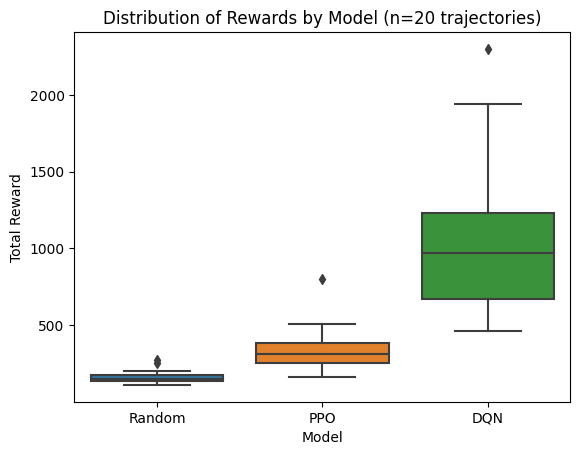

In [110]:
plt.title('Distribution of Rewards by Model (n=20 trajectories)')
sns.boxplot(x = df_plt['Scenario'], y = df_plt['Reward'])
plt.ylabel('Total Reward')
plt.xlabel('Model')
plt.savefig('midterm_rewards_dist.png')

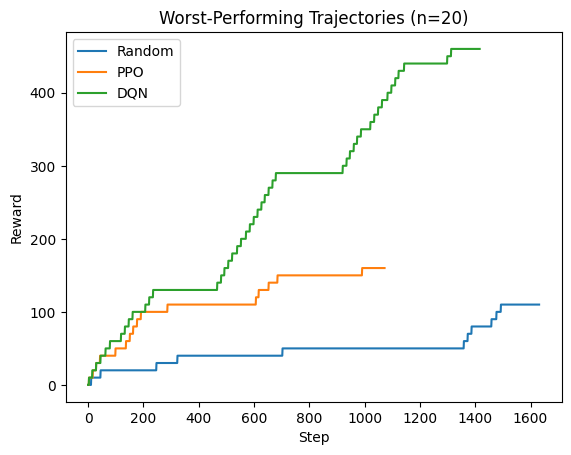

In [107]:
plt.title('Worst-Performing Trajectories (n=20)')
plt.plot(random_bad, label='Random')
plt.plot(ppo_bad, label='PPO')
plt.plot(dqn_bad, label='DQN')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.savefig('midterm_worst_traj.png')

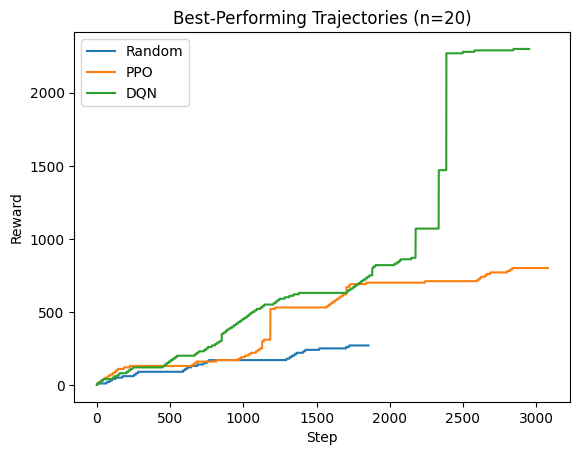

In [108]:
plt.title('Best-Performing Trajectories (n=20)')
plt.plot(random_good, label='Random')
plt.plot(ppo_good, label='PPO')
plt.plot(dqn_good, label='DQN')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.savefig('midterm_best_traj.png')

In [18]:
# metrics_path = '/project/logs/DQN/20221106_193517/'

In [19]:
# with open(os.path.join(metrics_path, 'metrics.pickle'), 'rb') as pkl:
#         metrics = pickle.load(pkl)

In [20]:
# metrics = [metric[265:] for metric in metrics]

In [21]:
# traj_rewards = []
# for traj in metrics:
#     rewards = 0
#     for step in traj:
#         rewards += step[0]
#         if step[0] != 0:
#             print(step, step[0])
#     traj_rewards.append(rewards)

In [46]:
# steps_to_term = [len(metrics[i]) for i in range(len(metrics))]

In [47]:
# steps_to_term.sort()

In [43]:
# steps_to_term

In [22]:
# rewards_agg = []
# for traj in metrics:
#     rewards = [step[0] for step in traj[0:1000]]
#     rewards_agg.append(rewards)

In [23]:
# rewards_agg = np.array(rewards_agg)

In [24]:
# rewards_agg.shape

In [25]:
# len(rewards_agg)

In [26]:
# rewards_avg = rewards_agg.cumsum(axis=1).sum(axis=0) / len(rewards_agg)

In [27]:
# rewards_std = rewards_agg.std(axis=0)

In [28]:
# steps = np.linspace(1, len(rewards_avg), num=1000)

In [29]:
# steps = np.linspace(0, 1000, 11)

In [30]:
# filter_indices = [0,99,199,299,399,499,599,699,799,899,999]

In [31]:
# rewards_plt = rewards_avg[filter_indices]

In [32]:
# std_plt = rewards_std[filter_indices]

In [33]:
# rewards_std

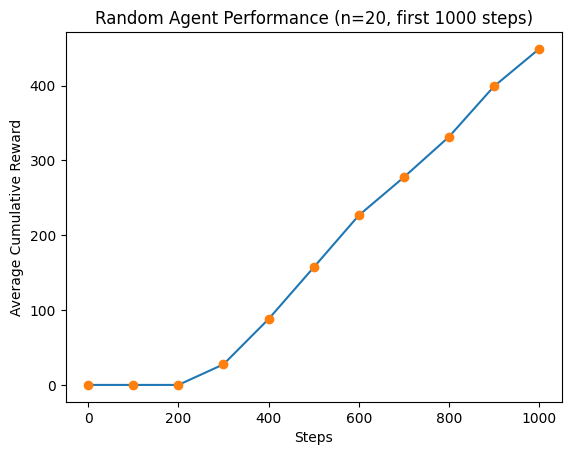

In [36]:
# plt.title('Random Agent Performance (n=20, first 1000 steps)')
# plt.xlabel('Steps')
# plt.ylabel('Average Cumulative Reward')
# plt.plot(steps, rewards_plt)
# plt.errorbar(steps, rewards_plt, yerr = std_plt, fmt ='o')
# plt.savefig('random_agent_performance.png')